#### By: Peyman Shahidi
#### Created: Oct 9, 2025

<br>

In [108]:
#Python
import getpass
import numpy as np
import pandas as pd
from collections import defaultdict
import itertools
import random 

## formatting number to appear comma separated and with two digits after decimal: e.g, 1000 shown as 1,000.00
pd.set_option('float_format', "{:,.2f}".format)

import matplotlib.pyplot as plt
#%matplotlib inline
#from matplotlib.legend import Legend

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)

In [109]:
main_folder_path = ".."
input_data_path = f"{main_folder_path}/data"
output_data_path = f'{input_data_path}/computed_objects'
output_plot_path = f"{main_folder_path}/writeup/plots/taskcounts_aiexposure"

In [110]:
# Create directories if they don't exist
import os

for path in [output_data_path, output_plot_path]:
    if not os.path.exists(path):
        os.makedirs(path)

In [111]:
# Read O*NET data
ONET = pd.read_csv(f'{input_data_path}/computed_objects/ONET_cleaned_tasks.csv')

# Remove apostrophes for consistency
ONET = ONET.applymap(lambda x: x.replace("'", "") if isinstance(x, str) else x)

# Drop DWA columns to avoid double counting
# Note: In ~4k instances, the same task is mapped to multiple DWAs
ONET = ONET.drop(columns=['DWA ID', 'DWA Title'])

# Remove duplicate rows
rows_before = len(ONET)
print(f"Number of rows before removing duplicates: {rows_before:,}")
ONET = ONET.drop_duplicates().reset_index(drop=True)
rows_after = len(ONET)
print(f"Number of rows after removing duplicates: {rows_after:,}")
print(f"Duplicates removed: {rows_before - rows_after}")

# Print length of dataset
print(f"Number of rows in ONET dataset: {len(ONET):,}")

ONET.head(5)

Number of rows before removing duplicates: 22,310
Number of rows after removing duplicates: 17,953
Duplicates removed: 4357
Number of rows in ONET dataset: 17,953


,O*NET-SOC Code,Occupation Title,Task ID,Task Title,Task Type,Job Zone,Task_Time_Percentage,FT_Daily,FT_Hourly or more,FT_More than monthly,...,Importance,Relevance,Major_Group_Code,Major_Group_Title,Minor_Group_Code,Minor_Group_Title,Broad_Occupation_Code,Broad_Occupation_Title,Detailed_Occupation_Code,Detailed_Occupation_Title
0,11-1011.00,Chief Executives,8823,Direct or coordinate an organizations financia...,Core,5,9.62,46.67,5.26,11.04,...,4.54,94.19,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
1,11-1011.00,Chief Executives,8824,"Confer with board members, organization offici...",Core,5,9.49,25.27,4.81,27.41,...,4.15,98.79,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
2,11-1011.00,Chief Executives,8825,Analyze operations to evaluate performance of ...,Core,5,9.22,35.11,3.73,12.61,...,4.40,100.00,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
3,11-1011.00,Chief Executives,8826,"Direct, plan, or implement policies, objective...",Core,5,10.26,38.47,6.38,10.18,...,4.39,95.84,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
4,11-1011.00,Chief Executives,8827,"Prepare budgets for approval, including those ...",Core,5,1.46,7.87,0.65,18.43,...,4.17,90.47,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives


In [112]:
# Load GPTs are GPTs full label dataset
gpts_full_labels = pd.read_csv(f'{input_data_path}/GPTs-are-GPTs-main/data/full_labelset.tsv', sep="\t")
# Drop the first column
gpts_full_labels = gpts_full_labels.drop(gpts_full_labels.columns[:1], axis=1)

# Convert Task ID to integer
gpts_full_labels['Task ID'] = gpts_full_labels['Task ID'].astype(int)

# Remove apostrophes for consistency
gpts_full_labels = gpts_full_labels.applymap(lambda x: x.replace("'", "") if isinstance(x, str) else x)

# Rename columns
gpts_full_labels = gpts_full_labels.rename(columns={
    'Task': 'Task Title',
    'Title': 'Occupation Title'
})

# Print length of dataset
print(f"Number of rows in GPTs full labels dataset: {len(gpts_full_labels):,}")


gpts_full_labels.head(5)

Number of rows in GPTs full labels dataset: 19,265


,O*NET-SOC Code,Task ID,Task Title,Task Type,Occupation Title,human_exposure_agg,gpt4_exposure,gpt4_exposure_alt_rubric,gpt_3_relevant,gpt4_automation,alpha,beta,gamma,automation,human_labels
0,11-1011.00,8823,Direct or coordinate an organizations financia...,Core,Chief Executives,E0,E2,E2,False,T2,0.00,0.50,1.00,0.50,E0
1,11-1011.00,8831,Appoint department heads or managers and assig...,Core,Chief Executives,E0,E0,E0,False,T1,0.00,0.00,0.00,0.25,E0
2,11-1011.00,8825,Analyze operations to evaluate performance of ...,Core,Chief Executives,E2,E2,E2,False,T2,0.00,0.50,1.00,0.50,E2
3,11-1011.00,8826,"Direct, plan, or implement policies, objective...",Core,Chief Executives,E0,E2,E0,False,T1,0.00,0.50,1.00,0.25,E0
4,11-1011.00,8827,"Prepare budgets for approval, including those ...",Core,Chief Executives,E2,E2,E2,False,T2,0.00,0.50,1.00,0.50,E2


In [113]:
# Merge with ONET dataset to get hierarchical codes and titles
ONET = ONET.merge(gpts_full_labels, on=['O*NET-SOC Code', 'Occupation Title', 'Task ID', 'Task Title', 'Task Type'], how='left')
ONET

# Check how many tasks were not matched
unmatched_tasks = ONET[ONET['gpt4_exposure'].isna()]
print(f"Number of unmatched tasks: {len(unmatched_tasks):,}")

Number of unmatched tasks: 0


In [114]:
# Load the original ONET dataset to get DWA information back
ONET_with_DWAs = pd.read_csv(f'{input_data_path}/computed_objects/ONET_cleaned_tasks.csv')

# Remove apostrophes for consistency
ONET_with_DWAs = ONET_with_DWAs.applymap(lambda x: x.replace("'", "") if isinstance(x, str) else x)

# Merge with the full labelset to get exposure ratings
ONET_with_DWAs_labeled = ONET_with_DWAs.merge(
    gpts_full_labels, 
    on=['O*NET-SOC Code', 'Occupation Title', 'Task ID', 'Task Title', 'Task Type'], 
    how='left'
)

print(f"ONET dataset with DWAs and exposure labels: {len(ONET_with_DWAs_labeled):,} rows")
print(f"Rows with missing exposure labels: {ONET_with_DWAs_labeled['gpt4_exposure'].isna().sum():,}")

# Now analyze DWAs with multiple tasks
print("\n" + "="*80)
print("ANALYSIS: DWAs WITH MULTIPLE TASKS")
print("="*80)

# Group by DWA to count tasks per DWA
dwa_task_counts = ONET_with_DWAs_labeled.groupby(['DWA ID', 'DWA Title']).agg({
    'Task ID': 'nunique',  # Number of unique tasks per DWA
    'gpt4_exposure': 'nunique',  # Number of unique GPT-4 exposure ratings per DWA
    'human_labels': 'nunique'    # Number of unique human labels per DWA
}).reset_index()

# Rename columns for clarity
dwa_task_counts = dwa_task_counts.rename(columns={
    'Task ID': 'num_unique_tasks',
    'gpt4_exposure': 'num_unique_gpt4_ratings',
    'human_labels': 'num_unique_human_ratings'
})

# Filter for DWAs with more than one task
dwas_multiple_tasks = dwa_task_counts[dwa_task_counts['num_unique_tasks'] > 1].copy()

print(f"\nTotal number of unique DWAs: {len(dwa_task_counts):,}")
print(f"DWAs with multiple tasks: {len(dwas_multiple_tasks):,}")
print(f"Percentage of DWAs with multiple tasks: {len(dwas_multiple_tasks)/len(dwa_task_counts)*100:.1f}%")

# Sort by number of tasks (descending) to see DWAs with most tasks first
dwas_multiple_tasks = dwas_multiple_tasks.sort_values('num_unique_tasks', ascending=False)

print(f"\nTop 10 DWAs with most tasks:")
print(dwas_multiple_tasks.head(10).to_string(index=False))

# Summary statistics for DWAs with multiple tasks
print(f"\n" + "-"*50)
print("SUMMARY STATISTICS FOR DWAs WITH MULTIPLE TASKS:")
print("-"*50)

print(f"Number of tasks per DWA:")
print(f"  Min: {dwas_multiple_tasks['num_unique_tasks'].min()}")
print(f"  Max: {dwas_multiple_tasks['num_unique_tasks'].max()}")
print(f"  Mean: {dwas_multiple_tasks['num_unique_tasks'].mean():.2f}")
print(f"  Median: {dwas_multiple_tasks['num_unique_tasks'].median():.1f}")

print(f"\nNumber of unique GPT-4 ratings per DWA:")
print(f"  Min: {dwas_multiple_tasks['num_unique_gpt4_ratings'].min()}")
print(f"  Max: {dwas_multiple_tasks['num_unique_gpt4_ratings'].max()}")
print(f"  Mean: {dwas_multiple_tasks['num_unique_gpt4_ratings'].mean():.2f}")

print(f"\nNumber of unique Human ratings per DWA:")
print(f"  Min: {dwas_multiple_tasks['num_unique_human_ratings'].min()}")
print(f"  Max: {dwas_multiple_tasks['num_unique_human_ratings'].max()}")
print(f"  Mean: {dwas_multiple_tasks['num_unique_human_ratings'].mean():.2f}")

dwas_multiple_tasks

ONET dataset with DWAs and exposure labels: 22,310 rows
Rows with missing exposure labels: 0

ANALYSIS: DWAs WITH MULTIPLE TASKS

Total number of unique DWAs: 2,081
DWAs with multiple tasks: 2,052
Percentage of DWAs with multiple tasks: 98.6%

Top 10 DWAs with most tasks:
           DWA ID                                                     DWA Title  num_unique_tasks  num_unique_gpt4_ratings  num_unique_human_ratings
4.A.4.b.6.I07.D02                Advise students on academic or career matters.               120                        3                         3
4.A.3.b.6.I08.D03                        Record operational or production data.               109                        3                         3
4.A.2.a.1.I03.D04                                        Evaluate student work.               108                        3                         3
4.A.2.b.3.I01.D10                         Research topics in area of expertise.                74                        3         

,DWA ID,DWA Title,num_unique_tasks,num_unique_gpt4_ratings,num_unique_human_ratings
1977,4.A.4.b.6.I07.D02,Advise students on academic or career matters.,120,3,3
1407,4.A.3.b.6.I08.D03,Record operational or production data.,109,3,3
372,4.A.2.a.1.I03.D04,Evaluate student work.,108,3,3
749,4.A.2.b.3.I01.D10,Research topics in area of expertise.,74,3,3
1449,4.A.3.b.6.I11.D04,Record patient medical histories.,69,3,3
...,...,...,...,...,...
1596,4.A.4.a.3.I02.D02,Present sustainable products or services infor...,2,2,1
810,4.A.2.b.6.I02.D05,Adjust routes or speeds as necessary.,2,1,1
537,4.A.2.b.1.I03.D01,Authorize construction activities.,2,1,2
124,4.A.1.a.2.I02.D01,Monitor industrial energy consumption or manag...,2,1,2


In [115]:
# Detailed analysis of exposure rating distributions
print("\n" + "="*80)
print("DETAILED EXPOSURE RATING ANALYSIS")
print("="*80)

# Count how many DWAs have different numbers of unique ratings
print("\nDistribution of unique GPT-4 exposure ratings per DWA:")
gpt4_dist = dwas_multiple_tasks['num_unique_gpt4_ratings'].value_counts().sort_index()
for rating_count, num_dwas in gpt4_dist.items():
    percentage = (num_dwas / len(dwas_multiple_tasks)) * 100
    print(f"  {rating_count} unique rating(s): {num_dwas:,} DWAs ({percentage:.1f}%)")

print("\nDistribution of unique Human exposure ratings per DWA:")
human_dist = dwas_multiple_tasks['num_unique_human_ratings'].value_counts().sort_index()
for rating_count, num_dwas in human_dist.items():
    percentage = (num_dwas / len(dwas_multiple_tasks)) * 100
    print(f"  {rating_count} unique rating(s): {num_dwas:,} DWAs ({percentage:.1f}%)")

# Let's look at specific examples of DWAs with varying exposure ratings
print("\n" + "-"*60)
print("EXAMPLES OF DWAs WITH DIFFERENT EXPOSURE PATTERNS:")
print("-"*60)

# Example 1: DWA with 1 unique GPT-4 rating but multiple tasks
example_1_uniform = dwas_multiple_tasks[dwas_multiple_tasks['num_unique_gpt4_ratings'] == 1].iloc[0]
dwa_id_1 = example_1_uniform['DWA ID']
print(f"\nExample 1 - Uniform exposure (1 unique GPT-4 rating):")
print(f"DWA: {example_1_uniform['DWA Title']} ({dwa_id_1})")
print(f"Number of tasks: {example_1_uniform['num_unique_tasks']}")

# Show the tasks and their ratings for this DWA
example_1_details = ONET_with_DWAs_labeled[ONET_with_DWAs_labeled['DWA ID'] == dwa_id_1][
    ['Task Title', 'gpt4_exposure', 'human_labels']
].drop_duplicates()
print(f"Sample tasks and ratings:")
print(example_1_details.head().to_string(index=False))

# Example 2: DWA with 3 unique GPT-4 ratings
example_2_varied = dwas_multiple_tasks[dwas_multiple_tasks['num_unique_gpt4_ratings'] == 3].iloc[0]
dwa_id_2 = example_2_varied['DWA ID']
print(f"\nExample 2 - Varied exposure (3 unique GPT-4 ratings):")
print(f"DWA: {example_2_varied['DWA Title']} ({dwa_id_2})")
print(f"Number of tasks: {example_2_varied['num_unique_tasks']}")

# Show the exposure distribution for this DWA
example_2_details = ONET_with_DWAs_labeled[ONET_with_DWAs_labeled['DWA ID'] == dwa_id_2]
gpt4_counts = example_2_details['gpt4_exposure'].value_counts()
human_counts = example_2_details['human_labels'].value_counts()

print(f"GPT-4 exposure distribution:")
for rating, count in gpt4_counts.items():
    print(f"  {rating}: {count} tasks")

print(f"Human exposure distribution:")
for rating, count in human_counts.items():
    print(f"  {rating}: {count} tasks")

# Show some sample tasks with different ratings
print(f"Sample tasks with different ratings:")
sample_tasks = example_2_details[['Task Title', 'gpt4_exposure', 'human_labels']].drop_duplicates()
print(sample_tasks.head(10).to_string(index=False))


DETAILED EXPOSURE RATING ANALYSIS

Distribution of unique GPT-4 exposure ratings per DWA:
  1 unique rating(s): 830 DWAs (40.4%)
  2 unique rating(s): 905 DWAs (44.1%)
  3 unique rating(s): 317 DWAs (15.4%)

Distribution of unique Human exposure ratings per DWA:
  1 unique rating(s): 1,059 DWAs (51.6%)
  2 unique rating(s): 716 DWAs (34.9%)
  3 unique rating(s): 277 DWAs (13.5%)

------------------------------------------------------------
EXAMPLES OF DWAs WITH DIFFERENT EXPOSURE PATTERNS:
------------------------------------------------------------

Example 1 - Uniform exposure (1 unique GPT-4 rating):
DWA: Clean production equipment. (4.A.3.a.1.I03.D21)
Number of tasks: 66
Sample tasks and ratings:
                                                                                                               Task Title gpt4_exposure human_labels
                                                                Inspect, clean, and assemble molds before beginning work.            E0     

In [116]:
# Analysis of implications for exposure measurement
print("\n" + "="*80)
print("IMPLICATIONS FOR EXPOSURE MEASUREMENT")
print("="*80)

# Calculate how task-level vs DWA-level aggregation would differ
print("\nComparison of aggregation approaches:")
print("-" * 40)

# For DWAs with multiple exposure ratings, see how different aggregation methods compare
mixed_exposure_dwas = dwas_multiple_tasks[
    (dwas_multiple_tasks['num_unique_gpt4_ratings'] > 1) | 
    (dwas_multiple_tasks['num_unique_human_ratings'] > 1)
].copy()

print(f"DWAs with mixed exposure ratings: {len(mixed_exposure_dwas):,}")
print(f"Percentage of multi-task DWAs with mixed ratings: {len(mixed_exposure_dwas)/len(dwas_multiple_tasks)*100:.1f}%")

# Let's calculate different exposure measures for a few example DWAs
print(f"\nExample calculations for DWAs with mixed ratings:")
print("-" * 50)

# Take the top 3 DWAs with most tasks and mixed ratings
example_dwas = mixed_exposure_dwas.head(3)

for idx, dwa_info in example_dwas.iterrows():
    dwa_id = dwa_info['DWA ID']
    dwa_title = dwa_info['DWA Title']
    
    # Get all tasks for this DWA
    dwa_tasks = ONET_with_DWAs_labeled[ONET_with_DWAs_labeled['DWA ID'] == dwa_id].copy()
    
    # Calculate task-level exposure metrics
    dwa_tasks["task_weight"] = dwa_tasks["Task Type"].map({"Core": 1.0, "Supplemental": 0.5}).fillna(1.0)
    
    # GPT-4 metrics
    dwa_tasks["gpt4_E1"] = (dwa_tasks["gpt4_exposure"] == "E1").astype(int)
    dwa_tasks["gpt4_E2"] = (dwa_tasks["gpt4_exposure"] == "E2").astype(int)
    
    gpt4_alpha = (dwa_tasks["gpt4_E1"] * dwa_tasks["task_weight"]).sum() / dwa_tasks["task_weight"].sum()
    gpt4_beta = gpt4_alpha + 0.5 * (dwa_tasks["gpt4_E2"] * dwa_tasks["task_weight"]).sum() / dwa_tasks["task_weight"].sum()
    
    # Human metrics
    dwa_tasks["human_E1"] = (dwa_tasks["human_labels"] == "E1").astype(int)
    dwa_tasks["human_E2"] = (dwa_tasks["human_labels"] == "E2").astype(int)
    
    human_alpha = (dwa_tasks["human_E1"] * dwa_tasks["task_weight"]).sum() / dwa_tasks["task_weight"].sum()
    human_beta = human_alpha + 0.5 * (dwa_tasks["human_E2"] * dwa_tasks["task_weight"]).sum() / dwa_tasks["task_weight"].sum()
    
    print(f"\nDWA: {dwa_title[:60]}...")
    print(f"  Tasks: {len(dwa_tasks)} | GPT-4 ratings: {dwa_info['num_unique_gpt4_ratings']} | Human ratings: {dwa_info['num_unique_human_ratings']}")
    print(f"  GPT-4 Alpha: {gpt4_alpha:.3f} | GPT-4 Beta: {gpt4_beta:.3f}")
    print(f"  Human Alpha: {human_alpha:.3f} | Human Beta: {human_beta:.3f}")
    
    # Show rating distribution
    gpt4_dist = dwa_tasks['gpt4_exposure'].value_counts().sort_index()
    human_dist = dwa_tasks['human_labels'].value_counts().sort_index()
    print(f"  GPT-4 distribution: {dict(gpt4_dist)}")
    print(f"  Human distribution: {dict(human_dist)}")

# Summary of key findings
print("\n" + "="*80)
print("KEY FINDINGS")
print("="*80)
print(f"✓ 98.6% of DWAs ({2052:,} out of {2081:,}) have multiple tasks associated with them")
print(f"✓ Among DWAs with multiple tasks:")
print(f"  - 59.6% have mixed GPT-4 exposure ratings (2 or 3 different ratings)")
print(f"  - 48.4% have mixed human exposure ratings (2 or 3 different ratings)")
print(f"✓ Maximum exposure diversity: 3 different rating levels per DWA")
print(f"✓ This variation within DWAs suggests that task-level analysis provides")
print(f"  more granular and potentially more accurate exposure measurements")
print(f"✓ DWA-level aggregation would smooth over important within-DWA variation")


IMPLICATIONS FOR EXPOSURE MEASUREMENT

Comparison of aggregation approaches:
----------------------------------------
DWAs with mixed exposure ratings: 1,413
Percentage of multi-task DWAs with mixed ratings: 68.9%

Example calculations for DWAs with mixed ratings:
--------------------------------------------------

DWA: Advise students on academic or career matters....
  Tasks: 120 | GPT-4 ratings: 3 | Human ratings: 3
  GPT-4 Alpha: 0.028 | GPT-4 Beta: 0.223
  Human Alpha: 0.127 | Human Beta: 0.469
  GPT-4 distribution: {'E0': 74, 'E1': 3, 'E2': 43}
  Human distribution: {'E0': 29, 'E1': 17, 'E2': 74}

DWA: Record operational or production data....
  Tasks: 109 | GPT-4 ratings: 3 | Human ratings: 3
  GPT-4 Alpha: 0.720 | GPT-4 Beta: 0.788
  Human Alpha: 0.021 | Human Beta: 0.476
  GPT-4 distribution: {'E0': 15, 'E1': 78, 'E2': 16}
  Human distribution: {'E0': 7, 'E1': 2, 'E2': 100}

DWA: Evaluate student work....
  Tasks: 108 | GPT-4 ratings: 3 | Human ratings: 3
  GPT-4 Alpha: 0.075

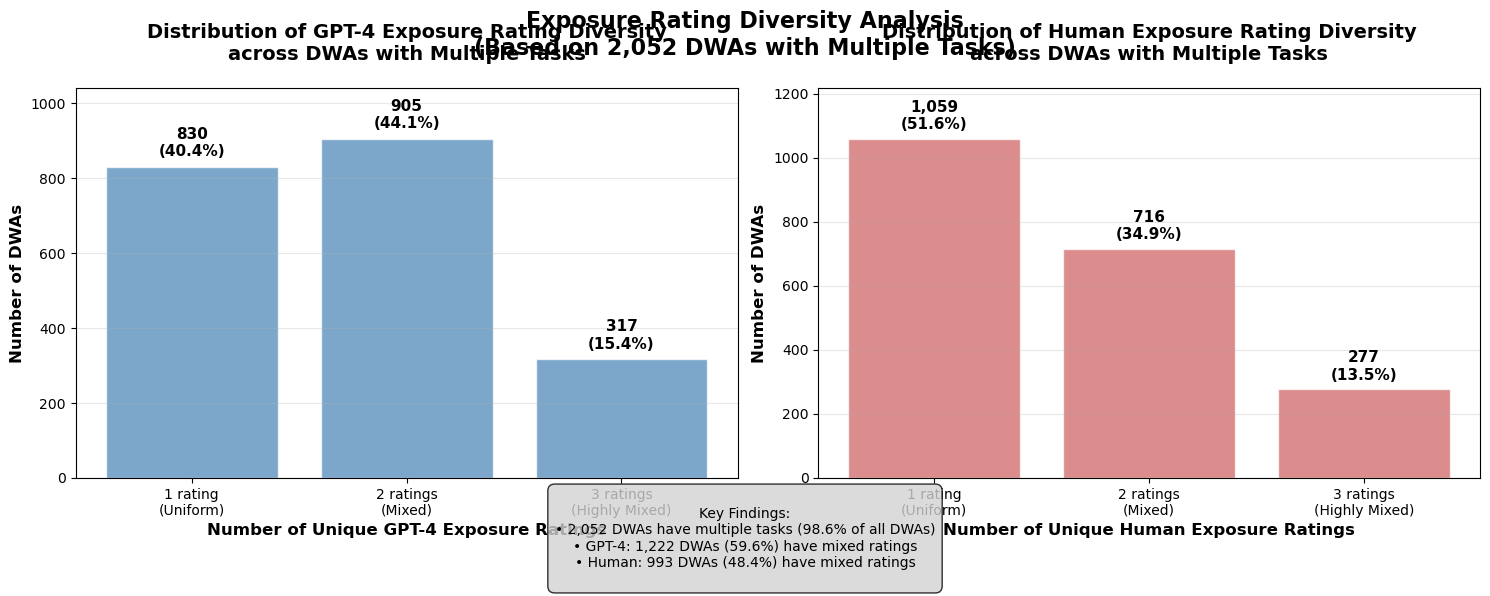

✓ Histograms showing DWA exposure rating diversity saved and displayed


In [117]:
# Create histograms showing distribution of unique exposure ratings per DWA
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# GPT-4 exposure histogram
gpt4_counts = dwas_multiple_tasks['num_unique_gpt4_ratings'].value_counts().sort_index()
bars1 = ax1.bar(gpt4_counts.index, gpt4_counts.values, color='steelblue', alpha=0.7, edgecolor='white', linewidth=1)

# Add percentage labels on bars
total_dwas = len(dwas_multiple_tasks)
for bar, count in zip(bars1, gpt4_counts.values):
    percentage = (count / total_dwas) * 100
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 20,
             f'{count:,}\n({percentage:.1f}%)', 
             ha='center', va='bottom', fontweight='bold', fontsize=11)

ax1.set_xlabel('Number of Unique GPT-4 Exposure Ratings', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of DWAs', fontsize=12, fontweight='bold')
ax1.set_title('Distribution of GPT-4 Exposure Rating Diversity\nacross DWAs with Multiple Tasks', 
              fontsize=14, fontweight='bold', pad=20)
ax1.set_xticks([1, 2, 3])
ax1.set_xticklabels(['1 rating\n(Uniform)', '2 ratings\n(Mixed)', '3 ratings\n(Highly Mixed)'])
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim(0, max(gpt4_counts.values) * 1.15)

# Human exposure histogram
human_counts = dwas_multiple_tasks['num_unique_human_ratings'].value_counts().sort_index()
bars2 = ax2.bar(human_counts.index, human_counts.values, color='indianred', alpha=0.7, edgecolor='white', linewidth=1)

# Add percentage labels on bars
for bar, count in zip(bars2, human_counts.values):
    percentage = (count / total_dwas) * 100
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 20,
             f'{count:,}\n({percentage:.1f}%)', 
             ha='center', va='bottom', fontweight='bold', fontsize=11)

ax2.set_xlabel('Number of Unique Human Exposure Ratings', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of DWAs', fontsize=12, fontweight='bold')
ax2.set_title('Distribution of Human Exposure Rating Diversity\nacross DWAs with Multiple Tasks', 
              fontsize=14, fontweight='bold', pad=20)
ax2.set_xticks([1, 2, 3])
ax2.set_xticklabels(['1 rating\n(Uniform)', '2 ratings\n(Mixed)', '3 ratings\n(Highly Mixed)'])
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_ylim(0, max(human_counts.values) * 1.15)

# Add overall statistics as text
fig.suptitle(f'Exposure Rating Diversity Analysis\n(Based on {total_dwas:,} DWAs with Multiple Tasks)', 
             fontsize=16, fontweight='bold', y=0.98)

# Add summary statistics
summary_text = f"""
Key Findings:
• {total_dwas:,} DWAs have multiple tasks (98.6% of all DWAs)
• GPT-4: {gpt4_counts[2] + gpt4_counts[3]:,} DWAs ({((gpt4_counts[2] + gpt4_counts[3]) / total_dwas * 100):.1f}%) have mixed ratings
• Human: {human_counts[2] + human_counts[3]:,} DWAs ({((human_counts[2] + human_counts[3]) / total_dwas * 100):.1f}%) have mixed ratings
"""

plt.figtext(0.5, 0.02, summary_text, ha='center', va='bottom', fontsize=10, 
            bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))

plt.tight_layout()
plt.subplots_adjust(top=0.85, bottom=0.20)

# Save the plot
plt.savefig(f'{output_plot_path}/dwa_exposure_diversity_histograms.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Histograms showing DWA exposure rating diversity saved and displayed")

In [118]:
# Create dataset with exposure rating fractions for DWAs with multiple exposure measures
print("\n" + "="*80)
print("EXPOSURE RATING FRACTIONS FOR DWAs WITH MULTIPLE MEASURES")
print("="*80)

# Function to calculate exposure fractions for a DWA
def calculate_exposure_fractions(dwa_tasks, exposure_col, prefix):
    """Calculate the fraction of tasks in each exposure category for a DWA"""
    total_tasks = len(dwa_tasks)
    
    # Count tasks in each exposure category
    e0_count = (dwa_tasks[exposure_col] == 'E0').sum()
    e1_count = (dwa_tasks[exposure_col] == 'E1').sum()
    e2_count = (dwa_tasks[exposure_col] == 'E2').sum()
    
    # Calculate fractions
    e0_fraction = e0_count / total_tasks if total_tasks > 0 else 0
    e1_fraction = e1_count / total_tasks if total_tasks > 0 else 0
    e2_fraction = e2_count / total_tasks if total_tasks > 0 else 0
    
    return {
        f'{prefix}_E0_fraction': e0_fraction,
        f'{prefix}_E1_fraction': e1_fraction,
        f'{prefix}_E2_fraction': e2_fraction,
        f'{prefix}_E0_count': e0_count,
        f'{prefix}_E1_count': e1_count,
        f'{prefix}_E2_count': e2_count,
        'total_tasks': total_tasks
    }

# Filter DWAs that have multiple exposure measures (mixed ratings)
mixed_gpt4_dwas = dwas_multiple_tasks[dwas_multiple_tasks['num_unique_gpt4_ratings'] > 1]['DWA ID'].tolist()
mixed_human_dwas = dwas_multiple_tasks[dwas_multiple_tasks['num_unique_human_ratings'] > 1]['DWA ID'].tolist()

# Get all DWAs with any mixed ratings
all_mixed_dwas = list(set(mixed_gpt4_dwas + mixed_human_dwas))

print(f"DWAs with mixed GPT-4 ratings: {len(mixed_gpt4_dwas):,}")
print(f"DWAs with mixed Human ratings: {len(mixed_human_dwas):,}")
print(f"DWAs with any mixed ratings: {len(all_mixed_dwas):,}")

# Create exposure fractions dataset
exposure_fractions_data = []

for dwa_id in all_mixed_dwas:
    # Get all tasks for this DWA
    dwa_tasks = ONET_with_DWAs_labeled[ONET_with_DWAs_labeled['DWA ID'] == dwa_id].copy()
    
    if len(dwa_tasks) == 0:
        continue
    
    # Get DWA info
    dwa_info = dwas_multiple_tasks[dwas_multiple_tasks['DWA ID'] == dwa_id].iloc[0]
    
    # Calculate GPT-4 exposure fractions
    gpt4_fractions = calculate_exposure_fractions(dwa_tasks, 'gpt4_exposure', 'gpt4')
    
    # Calculate Human exposure fractions
    human_fractions = calculate_exposure_fractions(dwa_tasks, 'human_labels', 'human')
    
    # Combine all data
    row_data = {
        'DWA_ID': dwa_id,
        'DWA_Title': dwa_info['DWA Title'],
        'num_unique_tasks': dwa_info['num_unique_tasks'],
        'num_unique_gpt4_ratings': dwa_info['num_unique_gpt4_ratings'],
        'num_unique_human_ratings': dwa_info['num_unique_human_ratings'],
        'has_mixed_gpt4': dwa_info['num_unique_gpt4_ratings'] > 1,
        'has_mixed_human': dwa_info['num_unique_human_ratings'] > 1,
    }
    
    # Add GPT-4 and Human fractions
    row_data.update(gpt4_fractions)
    row_data.update(human_fractions)
    
    exposure_fractions_data.append(row_data)

# Convert to DataFrame
exposure_fractions_df = pd.DataFrame(exposure_fractions_data)

# Sort by number of tasks (descending)
exposure_fractions_df = exposure_fractions_df.sort_values('num_unique_tasks', ascending=False)

print(f"\nCreated exposure fractions dataset with {len(exposure_fractions_df):,} DWAs")

# Display summary statistics
print(f"\nSUMMARY STATISTICS:")
print(f"GPT-4 Exposure Fractions:")
print(f"  E0 fraction - Mean: {exposure_fractions_df['gpt4_E0_fraction'].mean():.3f}, Std: {exposure_fractions_df['gpt4_E0_fraction'].std():.3f}")
print(f"  E1 fraction - Mean: {exposure_fractions_df['gpt4_E1_fraction'].mean():.3f}, Std: {exposure_fractions_df['gpt4_E1_fraction'].std():.3f}")
print(f"  E2 fraction - Mean: {exposure_fractions_df['gpt4_E2_fraction'].mean():.3f}, Std: {exposure_fractions_df['gpt4_E2_fraction'].std():.3f}")

print(f"\nHuman Exposure Fractions:")
print(f"  E0 fraction - Mean: {exposure_fractions_df['human_E0_fraction'].mean():.3f}, Std: {exposure_fractions_df['human_E0_fraction'].std():.3f}")
print(f"  E1 fraction - Mean: {exposure_fractions_df['human_E1_fraction'].mean():.3f}, Std: {exposure_fractions_df['human_E1_fraction'].std():.3f}")
print(f"  E2 fraction - Mean: {exposure_fractions_df['human_E2_fraction'].mean():.3f}, Std: {exposure_fractions_df['human_E2_fraction'].std():.3f}")

# Save the dataset
exposure_fractions_df.to_csv(f'{output_data_path}/dwa_exposure_fractions.csv', index=False)
print(f"\n✓ Saved exposure fractions dataset to: {output_data_path}/dwa_exposure_fractions.csv")

# Display first 10 rows
print(f"\nFirst 10 DWAs with mixed exposure ratings:")
display_cols = ['DWA_Title', 'num_unique_tasks', 'num_unique_gpt4_ratings', 'num_unique_human_ratings',
                'gpt4_E0_fraction', 'gpt4_E1_fraction', 'gpt4_E2_fraction',
                'human_E0_fraction', 'human_E1_fraction', 'human_E2_fraction']

exposure_fractions_df[display_cols].head(10)


EXPOSURE RATING FRACTIONS FOR DWAs WITH MULTIPLE MEASURES
DWAs with mixed GPT-4 ratings: 1,222
DWAs with mixed Human ratings: 993
DWAs with any mixed ratings: 1,413

Created exposure fractions dataset with 1,413 DWAs

SUMMARY STATISTICS:
GPT-4 Exposure Fractions:
  E0 fraction - Mean: 0.326, Std: 0.335
  E1 fraction - Mean: 0.165, Std: 0.247
  E2 fraction - Mean: 0.509, Std: 0.317

Human Exposure Fractions:
  E0 fraction - Mean: 0.442, Std: 0.390
  E1 fraction - Mean: 0.184, Std: 0.307
  E2 fraction - Mean: 0.374, Std: 0.368

✓ Saved exposure fractions dataset to: ../data/computed_objects/dwa_exposure_fractions.csv

First 10 DWAs with mixed exposure ratings:

Created exposure fractions dataset with 1,413 DWAs

SUMMARY STATISTICS:
GPT-4 Exposure Fractions:
  E0 fraction - Mean: 0.326, Std: 0.335
  E1 fraction - Mean: 0.165, Std: 0.247
  E2 fraction - Mean: 0.509, Std: 0.317

Human Exposure Fractions:
  E0 fraction - Mean: 0.442, Std: 0.390
  E1 fraction - Mean: 0.184, Std: 0.307
  E2 f

,DWA_Title,num_unique_tasks,num_unique_gpt4_ratings,num_unique_human_ratings,gpt4_E0_fraction,gpt4_E1_fraction,gpt4_E2_fraction,human_E0_fraction,human_E1_fraction,human_E2_fraction
51,Advise students on academic or career matters.,120,3,3,0.62,0.03,0.36,0.24,0.14,0.62
23,Record operational or production data.,109,3,3,0.14,0.72,0.15,0.06,0.02,0.92
717,Evaluate student work.,108,3,3,0.05,0.07,0.88,0.08,0.03,0.89
1154,Research topics in area of expertise.,74,3,3,0.03,0.05,0.92,0.01,0.50,0.49
1114,Record patient medical histories.,69,3,3,0.04,0.46,0.49,0.06,0.01,0.93
393,"Order materials, supplies, or equipment.",68,3,3,0.25,0.09,0.66,0.78,0.06,0.16
902,"Maintain inventories of materials, equipment, ...",65,3,3,0.37,0.11,0.52,0.82,0.05,0.14
949,"Explain regulations, policies, or procedures.",60,3,2,0.28,0.43,0.28,0.13,0.87,0.00
1129,Collaborate with healthcare professionals to p...,59,3,3,0.37,0.02,0.61,0.20,0.02,0.78
910,Measure dimensions of completed products or wo...,58,2,1,0.76,0.00,0.24,1.00,0.00,0.00


In [119]:
# Reconstruct the occ_level exposure dataset from the original paper
def compute_exposure_shares(df, exposure_col, prefix):
    # Weight core vs. supplemental tasks (if column exists)
    df["task_weight"] = df["Task Type"].map({"Core": 1.0, "Supplemental": 0.5}).fillna(1.0)

    # One-hot exposure indicators
    df[f"{prefix}_E1"] = (df[exposure_col] == "E1").astype(int)
    df[f"{prefix}_E2"] = (df[exposure_col] == "E2").astype(int)

    # Weighted shares per occupation
    occ_level = (
        df.groupby(["O*NET-SOC Code", "Occupation Title"])
        .apply(lambda x: pd.Series({
            f"{prefix}_E1_share": (x[f"{prefix}_E1"] * x["task_weight"]).sum() / x["task_weight"].sum(),
            f"{prefix}_E2_share": (x[f"{prefix}_E2"] * x["task_weight"]).sum() / x["task_weight"].sum(),
        }))
        .reset_index()
    )

    # Composite measures
    occ_level[f"{prefix}_E1_plus_halfE2"] = occ_level[f"{prefix}_E1_share"] + 0.5 * occ_level[f"{prefix}_E2_share"]
    occ_level[f"{prefix}_E1_plus_E2"]     = occ_level[f"{prefix}_E1_share"] + occ_level[f"{prefix}_E2_share"]

    occ_level = occ_level.drop(columns=[f'{prefix}_E2_share'])

    occ_level = occ_level.rename(columns={'gpt4_E1_share': 'gpt4_alpha',
                                          'gpt4_E1_plus_halfE2': 'gpt4_beta',
                                          'gpt4_E1_plus_E2': 'gpt4_gamma',
                                          'human_E1_share': 'human_alpha',
                                          'human_E1_plus_halfE2': 'human_beta',
                                          'human_E1_plus_E2': 'human_gamma'})

    return occ_level


# Compute exposure shares for GPT-4 and human ratings
gpt4_exposure_scores = compute_exposure_shares(ONET, "gpt4_exposure", "gpt4")
human_exposure_scores = compute_exposure_shares(ONET, "human_labels", "human")

# Merge GPT-4 and human exposure scores on occupation code and title
exposure_scores_occupation = pd.merge(gpt4_exposure_scores, human_exposure_scores, 
                                     on=["O*NET-SOC Code", "Occupation Title"])

# Save the combined exposure scores to CSV
# exposure_scores_occupation.to_csv(f'{output_data_path}/exposure_scores_occupation.csv', index=False)
# print(f"Saved combined exposure scores to: {output_data_path}/exposure_scores_occupation.csv")
print(f"Number of occupations: {len(exposure_scores_occupation)}")

# Display the results
exposure_scores_occupation

Number of occupations: 873


,O*NET-SOC Code,Occupation Title,gpt4_alpha,gpt4_beta,gpt4_gamma,human_alpha,human_beta,human_gamma
0,11-1011.00,Chief Executives,0.10,0.46,0.82,0.18,0.35,0.52
1,11-1011.03,Chief Sustainability Officers,0.17,0.56,0.94,0.06,0.39,0.72
2,11-1021.00,General and Operations Managers,0.00,0.48,0.96,0.12,0.38,0.65
3,11-2011.00,Advertising and Promotions Managers,0.00,0.49,0.97,0.32,0.57,0.82
4,11-2021.00,Marketing Managers,0.06,0.50,0.94,0.22,0.58,0.94
...,...,...,...,...,...,...,...,...
868,53-7071.00,Gas Compressor and Gas Pumping Station Operators,0.23,0.27,0.31,0.00,0.08,0.15
869,53-7072.00,"Pump Operators, Except Wellhead Pumpers",0.17,0.25,0.33,0.00,0.17,0.33
870,53-7073.00,Wellhead Pumpers,0.00,0.00,0.00,0.00,0.00,0.00
871,53-7081.00,Refuse and Recyclable Material Collectors,0.18,0.20,0.21,0.11,0.23,0.36


In [120]:
# Function to compute hierarchical exposure scores
def compute_hierarchical_exposure(df, code_col, title_col, exposure_col, prefix):
    """
    Compute exposure shares at a hierarchical level (e.g., Major Group, Minor Group).
    
    Parameters:
    - df: DataFrame with task-level data
    - code_col: Column name for the hierarchical code
    - title_col: Column name for the hierarchical title
    - exposure_col: Column with exposure ratings (e.g., 'gpt4_exposure')
    - prefix: Prefix for output columns (e.g., 'gpt4')
    
    Returns:
    - DataFrame with exposure measures at the hierarchical level
    """
    # Create a copy to avoid modifying original
    df_copy = df.copy()
    
    # Weight core vs. supplemental tasks
    df_copy["task_weight"] = df_copy["Task Type"].map({"Core": 1.0, "Supplemental": 0.5}).fillna(1.0)
    
    # One-hot exposure indicators
    df_copy[f"{prefix}_E1"] = (df_copy[exposure_col] == "E1").astype(int)
    df_copy[f"{prefix}_E2"] = (df_copy[exposure_col] == "E2").astype(int)
    
    # Filter out rows with NaN exposure values
    df_copy = df_copy[df_copy[exposure_col].notna()]
    
    # Weighted shares per hierarchical level
    level_exposure = (
        df_copy.groupby([code_col, title_col], as_index=False)
        .apply(lambda x: pd.Series({
            f"{prefix}_E1_share": (x[f"{prefix}_E1"] * x["task_weight"]).sum() / x["task_weight"].sum(),
            f"{prefix}_E2_share": (x[f"{prefix}_E2"] * x["task_weight"]).sum() / x["task_weight"].sum(),
        }), include_groups=False)
        .reset_index()
    )
    
    # Composite measures
    level_exposure[f"{prefix}_alpha"] = level_exposure[f"{prefix}_E1_share"]
    level_exposure[f"{prefix}_beta"] = level_exposure[f"{prefix}_E1_share"] + 0.5 * level_exposure[f"{prefix}_E2_share"]
    level_exposure[f"{prefix}_gamma"] = level_exposure[f"{prefix}_E1_share"] + level_exposure[f"{prefix}_E2_share"]
    
    # Drop E2_share and E1_share as they're not needed in final output
    level_exposure = level_exposure.drop(columns=[f'{prefix}_E2_share', f'{prefix}_E1_share'])
    
    # Rename to standard column names
    level_exposure = level_exposure.rename(columns={
        code_col: 'Code',
        title_col: 'Title'
    })
    
    return level_exposure


# Define hierarchical levels
hierarchical_levels = [
    ('Major_Group_Code', 'Major_Group_Title', 'Major Group'),
    ('Minor_Group_Code', 'Minor_Group_Title', 'Minor Group'),
    ('Broad_Occupation_Code', 'Broad_Occupation_Title', 'Broad Occupation'),
    ('Detailed_Occupation_Code', 'Detailed_Occupation_Title', 'Detailed Occupation')
]

# Compute exposure scores for each hierarchical level
for code_col, title_col, level_name in hierarchical_levels:
    # Compute GPT-4 exposure
    gpt4_exp = compute_hierarchical_exposure(ONET, code_col, title_col, 'gpt4_exposure', 'gpt4')
    
    # Compute human exposure
    human_exp = compute_hierarchical_exposure(ONET, code_col, title_col, 'human_labels', 'human')

    # Merge GPT-4 and human exposure scores
    combined_exp = pd.merge(gpt4_exp, human_exp, on=['Code', 'Title'])
    combined_exp['Level'] = level_name
    
    # Reorder columns
    combined_exp = combined_exp[['Level', 'Code', 'Title', 
                                  'gpt4_alpha', 'gpt4_beta', 'gpt4_gamma',
                                  'human_alpha', 'human_beta', 'human_gamma']]
    
    # Save to CSV
    filename = level_name.lower().replace(' ', '_')
    # combined_exp.to_csv(f'{output_data_path}/exposure_scores_{filename}.csv', index=False)
    # print(f"Saved {level_name} exposure scores: {len(combined_exp)} groups")


In [121]:
# Create a combined hierarchical exposure dataset (all 5 levels in one file)
all_exposure_levels = []

# Add hierarchical-level exposure scores in order from most aggregated to most granular
for code_col, title_col, level_name in hierarchical_levels:
    gpt4_exp = compute_hierarchical_exposure(ONET, code_col, title_col, 'gpt4_exposure', 'gpt4')
    human_exp = compute_hierarchical_exposure(ONET, code_col, title_col, 'human_labels', 'human')
    
    combined_exp = pd.merge(gpt4_exp, human_exp, on=['Code', 'Title'])
    combined_exp['Level'] = level_name
    combined_exp = combined_exp[['Level', 'Code', 'Title',
                                  'gpt4_alpha', 'gpt4_beta', 'gpt4_gamma',
                                  'human_alpha', 'human_beta', 'human_gamma']]
    
    all_exposure_levels.append(combined_exp)

# Add occupation-level exposure scores (most granular)
occupation_exposure = exposure_scores_occupation.copy()
occupation_exposure['Level'] = 'Occupation'
occupation_exposure = occupation_exposure.rename(columns={'O*NET-SOC Code': 'Code', 'Occupation Title': 'Title'})
occupation_exposure = occupation_exposure[['Level', 'Code', 'Title',
                                           'gpt4_alpha', 'gpt4_beta', 'gpt4_gamma',
                                           'human_alpha', 'human_beta', 'human_gamma']]
all_exposure_levels.append(occupation_exposure)

# Combine all 5 levels
exposure_scores_all_levels = pd.concat(all_exposure_levels, ignore_index=True)

# Save combined dataset
# exposure_scores_all_levels.to_csv(f'{output_data_path}/exposure_scores_all_levels.csv', index=False)

print(f"\nCombined Exposure Dataset (All 5 Levels):")
print(f"  Total rows: {len(exposure_scores_all_levels):,}")
print(f"\nBreakdown by level:")
for level_name in ['Major Group', 'Minor Group', 'Broad Occupation', 'Detailed Occupation', 'Occupation']:
    count = len(exposure_scores_all_levels[exposure_scores_all_levels['Level'] == level_name])
    print(f"  {level_name}: {count}")

exposure_scores_all_levels.head(5)


Combined Exposure Dataset (All 5 Levels):
  Total rows: 2,179

Breakdown by level:
  Major Group: 22
  Minor Group: 95
  Broad Occupation: 430
  Detailed Occupation: 759
  Occupation: 873


,Level,Code,Title,gpt4_alpha,gpt4_beta,gpt4_gamma,human_alpha,human_beta,human_gamma
0,Major Group,11-0000,Management Occupations,0.07,0.47,0.86,0.19,0.44,0.68
1,Major Group,13-0000,Business and Financial Operations Occupations,0.15,0.54,0.92,0.27,0.53,0.80
2,Major Group,15-0000,Computer and Mathematical Occupations,0.50,0.73,0.97,0.29,0.60,0.91
3,Major Group,17-0000,Architecture and Engineering Occupations,0.17,0.50,0.83,0.20,0.43,0.67
4,Major Group,19-0000,"Life, Physical, and Social Science Occupations",0.12,0.46,0.81,0.28,0.50,0.72


In [122]:
# Merge Task and DWA counts with exposure scores
hierarchical_task_counts = pd.read_csv(f'{output_data_path}/hierarchical_task_counts.csv')

# Merge on Level, Code, and Title
exposure_scores_with_counts = exposure_scores_all_levels.merge(
    hierarchical_task_counts[['Level', 'Code', 'Title', 'num_unique_tasks', 'num_unique_dwas']],
    on=['Level', 'Code', 'Title'], 
    how='left'
)

# Check merge statistics
print(f"\nMerge Statistics:")
print(f"  Rows before merge (exposure scores): {len(exposure_scores_all_levels):,}")
print(f"  Rows in task counts dataset: {len(hierarchical_task_counts):,}")
print(f"  Rows after merge: {len(exposure_scores_with_counts):,}")
print(f"  Rows with missing task counts: {exposure_scores_with_counts['num_unique_tasks'].isna().sum():,}")
print(f"  Rows with missing DWA counts: {exposure_scores_with_counts['num_unique_dwas'].isna().sum():,}")

# Show rows with missing values
if exposure_scores_with_counts['num_unique_tasks'].isna().sum() > 0:
    print(f"\nRows with missing task/DWA counts:")
    missing_rows = exposure_scores_with_counts[exposure_scores_with_counts['num_unique_tasks'].isna()]
    print(missing_rows[['Level', 'Code', 'Title']])
    
    # Drop rows with missing task counts
    exposure_scores_with_counts = exposure_scores_with_counts.dropna(subset=['num_unique_tasks', 'num_unique_dwas'])
    print(f"\nAfter dropping rows with missing counts: {len(exposure_scores_with_counts):,} rows remaining")
else:
    print(f"\n✓ All rows successfully merged!")

# Convert count columns to integers
exposure_scores_with_counts['num_unique_tasks'] = exposure_scores_with_counts['num_unique_tasks'].astype(int)
exposure_scores_with_counts['num_unique_dwas'] = exposure_scores_with_counts['num_unique_dwas'].astype(int)

# Save the combined dataset
exposure_scores_with_counts.to_csv(f'{output_data_path}/exposure_scores_with_counts.csv', index=False)

print(f"\nCombined Exposure + Task Counts Dataset:")
print(f"  Total rows: {len(exposure_scores_with_counts):,}")
print(f"\nFirst 10 rows:")
exposure_scores_with_counts.head(10)


Merge Statistics:
  Rows before merge (exposure scores): 2,179
  Rows in task counts dataset: 2,179
  Rows after merge: 2,179
  Rows with missing task counts: 2
  Rows with missing DWA counts: 2

Rows with missing task/DWA counts:
                    Level        Code                                Title
911   Detailed Occupation     33-3051  Police and Sheriffs Patrol Officers
1766           Occupation  33-3051.00  Police and Sheriffs Patrol Officers

After dropping rows with missing counts: 2,177 rows remaining

Combined Exposure + Task Counts Dataset:
  Total rows: 2,177

First 10 rows:


,Level,Code,Title,gpt4_alpha,gpt4_beta,gpt4_gamma,human_alpha,human_beta,human_gamma,num_unique_tasks,num_unique_dwas
0,Major Group,11-0000,Management Occupations,0.07,0.47,0.86,0.19,0.44,0.68,1063,0
1,Major Group,13-0000,Business and Financial Operations Occupations,0.15,0.54,0.92,0.27,0.53,0.80,871,0
2,Major Group,15-0000,Computer and Mathematical Occupations,0.50,0.73,0.97,0.29,0.60,0.91,606,0
3,Major Group,17-0000,Architecture and Engineering Occupations,0.17,0.50,0.83,0.20,0.43,0.67,1157,0
4,Major Group,19-0000,"Life, Physical, and Social Science Occupations",0.12,0.46,0.81,0.28,0.50,0.72,1168,0
5,Major Group,21-0000,Community and Social Service Occupations,0.11,0.32,0.53,0.22,0.35,0.49,296,0
6,Major Group,23-0000,Legal Occupations,0.10,0.49,0.87,0.10,0.41,0.72,125,0
7,Major Group,25-0000,Educational Instruction and Library Occupations,0.16,0.43,0.69,0.22,0.42,0.62,1494,0
8,Major Group,27-0000,"Arts, Design, Entertainment, Sports, and Media...",0.20,0.48,0.76,0.20,0.38,0.56,764,0
9,Major Group,29-0000,Healthcare Practitioners and Technical Occupat...,0.08,0.34,0.60,0.13,0.29,0.45,1541,0


In [123]:
# Combined plots: Create three figures (alpha, beta, gamma) with both Tasks and DWAs 
# in a single comprehensive layout for each exposure measure

# Define the levels in order from most aggregated to most granular
levels_to_plot = ['Major Group', 'Minor Group', 'Broad Occupation', 'Detailed Occupation', 'Occupation']

# Define exposure measures to use
exposure_measures = ['alpha', 'beta', 'gamma']

# Create one comprehensive plot for each exposure measure
for exposure_measure in exposure_measures:
    # Create figure with 5x2 subplots (5 levels × 2 exposure types)
    fig, axes = plt.subplots(5, 2, figsize=(18, 22))
    
    fig.suptitle(f'Tasks and DWAs vs {exposure_measure.capitalize()} Exposure Across Hierarchical Levels\n\n\n', 
                fontsize=18, fontweight='bold', y=0.995)
    
    # Calculate global x-axis limits for this exposure measure to ensure consistent scaling
    all_gpt4_values = []
    all_human_values = []
    
    for level_name in levels_to_plot:
        level_data = exposure_scores_with_counts[exposure_scores_with_counts['Level'] == level_name].copy()
        gpt4_vals = level_data[f'gpt4_{exposure_measure}'].values
        human_vals = level_data[f'human_{exposure_measure}'].values
        
        # Remove NaN values for range calculation
        gpt4_clean = gpt4_vals[~np.isnan(gpt4_vals)]
        human_clean = human_vals[~np.isnan(human_vals)]
        
        if len(gpt4_clean) > 0:
            all_gpt4_values.extend(gpt4_clean)
        if len(human_clean) > 0:
            all_human_values.extend(human_clean)
    
    # Set consistent x-axis limits with margins for a clean 0-1 range
    x_margin = 0.05  # 5% margin on each side
    gpt4_xlim = (-x_margin, 1 + x_margin)
    human_xlim = (-x_margin, 1 + x_margin)
    
    # Loop through each hierarchical level
    for level_idx, level_name in enumerate(levels_to_plot):
        # Filter data for current level
        level_data = exposure_scores_with_counts[exposure_scores_with_counts['Level'] == level_name].copy()
        n_obs = len(level_data)
        
        # Left column: GPT-4 exposure
        ax_gpt4 = axes[level_idx, 0]
        
        # Get data for both tasks and DWAs
        x_gpt4 = level_data[f'gpt4_{exposure_measure}'].values
        y_tasks = level_data['num_unique_tasks'].values
        y_dwas = level_data['num_unique_dwas'].values
        
        # Plot tasks (blue circles)
        ax_gpt4.scatter(x_gpt4, y_tasks, alpha=0.7, color='steelblue', edgecolors='white', 
                       linewidth=0.5, s=60, label='Tasks')
        
        # Plot DWAs (red triangles)
        ax_gpt4.scatter(x_gpt4, y_dwas, alpha=0.7, color='indianred', edgecolors='white', 
                       linewidth=0.5, s=60, marker='^', label='DWAs')
        
        # Fit and plot regression lines
        if len(x_gpt4) > 1 and not np.all(np.isnan(x_gpt4)):
            # Tasks regression line
            valid_idx_tasks = ~(np.isnan(x_gpt4) | np.isnan(y_tasks))
            if np.sum(valid_idx_tasks) > 1:
                x_clean = x_gpt4[valid_idx_tasks]
                y_clean = y_tasks[valid_idx_tasks]
                slope_tasks, intercept_tasks = np.polyfit(x_clean, y_clean, 1)
                x_fit = np.linspace(x_clean.min(), x_clean.max(), 100)
                y_fit_tasks = slope_tasks * x_fit + intercept_tasks
                ax_gpt4.plot(x_fit, y_fit_tasks, color='steelblue', linewidth=2, alpha=0.8, 
                           linestyle='-', label=f'Tasks slope: {slope_tasks:.2f}')
            
            # DWAs regression line
            valid_idx_dwas = ~(np.isnan(x_gpt4) | np.isnan(y_dwas))
            if np.sum(valid_idx_dwas) > 1:
                x_clean = x_gpt4[valid_idx_dwas]
                y_clean = y_dwas[valid_idx_dwas]
                slope_dwas, intercept_dwas = np.polyfit(x_clean, y_clean, 1)
                x_fit = np.linspace(x_clean.min(), x_clean.max(), 100)
                y_fit_dwas = slope_dwas * x_fit + intercept_dwas
                ax_gpt4.plot(x_fit, y_fit_dwas, color='indianred', linewidth=2, alpha=0.8, 
                           linestyle='--', label=f'DWAs slope: {slope_dwas:.2f}')
        
        ax_gpt4.set_xlabel(f'GPT-4 {exposure_measure.capitalize()} Exposure', fontsize=12)
        ax_gpt4.set_ylabel('Count', fontsize=12)
        ax_gpt4.set_title(f'{level_name} (n={n_obs}): GPT-4 Exposure', fontsize=13, fontweight='bold')
        ax_gpt4.grid(True, alpha=0.3)
        ax_gpt4.legend(fontsize=10, loc='upper right')
        ax_gpt4.set_xlim(gpt4_xlim)  # Set consistent x-axis limits (0-1 with margins)
        
        # Right column: Human exposure
        ax_human = axes[level_idx, 1]
        
        # Get data for both tasks and DWAs
        x_human = level_data[f'human_{exposure_measure}'].values
        
        # Plot tasks (blue circles)
        ax_human.scatter(x_human, y_tasks, alpha=0.7, color='steelblue', edgecolors='white', 
                        linewidth=0.5, s=60, label='Tasks')
        
        # Plot DWAs (red triangles)
        ax_human.scatter(x_human, y_dwas, alpha=0.7, color='indianred', edgecolors='white', 
                        linewidth=0.5, s=60, marker='^', label='DWAs')
        
        # Fit and plot regression lines
        if len(x_human) > 1 and not np.all(np.isnan(x_human)):
            # Tasks regression line
            valid_idx_tasks = ~(np.isnan(x_human) | np.isnan(y_tasks))
            if np.sum(valid_idx_tasks) > 1:
                x_clean = x_human[valid_idx_tasks]
                y_clean = y_tasks[valid_idx_tasks]
                slope_tasks_h, intercept_tasks_h = np.polyfit(x_clean, y_clean, 1)
                x_fit_h = np.linspace(x_clean.min(), x_clean.max(), 100)
                y_fit_tasks_h = slope_tasks_h * x_fit_h + intercept_tasks_h
                ax_human.plot(x_fit_h, y_fit_tasks_h, color='steelblue', linewidth=2, alpha=0.8, 
                            linestyle='-', label=f'Tasks slope: {slope_tasks_h:.2f}')
            
            # DWAs regression line
            valid_idx_dwas = ~(np.isnan(x_human) | np.isnan(y_dwas))
            if np.sum(valid_idx_dwas) > 1:
                x_clean = x_human[valid_idx_dwas]
                y_clean = y_dwas[valid_idx_dwas]
                slope_dwas_h, intercept_dwas_h = np.polyfit(x_clean, y_clean, 1)
                x_fit_h = np.linspace(x_clean.min(), x_clean.max(), 100)
                y_fit_dwas_h = slope_dwas_h * x_fit_h + intercept_dwas_h
                ax_human.plot(x_fit_h, y_fit_dwas_h, color='indianred', linewidth=2, alpha=0.8, 
                            linestyle='--', label=f'DWAs slope: {slope_dwas_h:.2f}')
        
        ax_human.set_xlabel(f'Human {exposure_measure.capitalize()} Exposure', fontsize=12)
        ax_human.set_ylabel('Count', fontsize=12)
        ax_human.set_title(f'{level_name} (n={n_obs}): Human Exposure', fontsize=13, fontweight='bold')
        ax_human.grid(True, alpha=0.3)
        ax_human.legend(fontsize=10, loc='upper right')
        ax_human.set_xlim(human_xlim)  # Set consistent x-axis limits (0-1 with margins)
    
    # Add main column headers
    axes[0, 0].text(0.5, 1.12, 'GPT-4 Exposure', transform=axes[0, 0].transAxes, 
                   ha='center', va='bottom', fontsize=16, fontweight='bold')
    axes[0, 1].text(0.5, 1.12, 'Human Exposure', transform=axes[0, 1].transAxes, 
                   ha='center', va='bottom', fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.96, hspace=0.35, wspace=0.25)
    
    # Save figure
    filename = f'tasks_and_dwas_vs_exposure_{exposure_measure}.png'
    plt.savefig(f'{output_plot_path}/{filename}', dpi=300, bbox_inches='tight')
    plt.close()

print(f"✓ Saved {len(exposure_measures)} comprehensive plots to: {output_plot_path}/")

✓ Saved 3 comprehensive plots to: ../writeup/plots/taskcounts_aiexposure/


In [124]:
# Regression analysis: Number of tasks/DWAs on GPT-4 and Human exposure measures
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Initialize list to store regression results
regression_results = []

# Define the levels and exposure measures (same as in plots)
levels_to_analyze = ['Major Group', 'Minor Group', 'Broad Occupation', 'Detailed Occupation', 'Occupation']
exposure_measures = ['alpha', 'beta', 'gamma']
dependent_vars = ['num_unique_tasks', 'num_unique_dwas']

# Function to perform regression and extract statistics
def run_regression(x, y, x_name, y_name, level_name, exposure_measure):
    """Run regression and return coefficient, std error, t-stat, p-value, R²"""
    # Remove any NaN values
    valid_idx = ~(np.isnan(x) | np.isnan(y))
    x_clean = x[valid_idx]
    y_clean = y[valid_idx]
    
    if len(x_clean) < 2:
        return None
    
    # Fit regression
    reg = LinearRegression().fit(x_clean.reshape(-1, 1), y_clean)
    y_pred = reg.predict(x_clean.reshape(-1, 1))
    
    # Calculate statistics
    n = len(x_clean)
    coeff = reg.coef_[0]
    intercept = reg.intercept_
    r_squared = r2_score(y_clean, y_pred)
    
    # Calculate standard error and t-statistic
    residuals = y_clean - y_pred
    mse = np.sum(residuals**2) / (n - 2)  # degrees of freedom: n - 2 for simple regression
    
    # Standard error of coefficient
    x_mean = np.mean(x_clean)
    ss_x = np.sum((x_clean - x_mean)**2)
    se_coeff = np.sqrt(mse / ss_x)
    
    # t-statistic and p-value
    t_stat = coeff / se_coeff
    p_value = 2 * (1 - stats.t.cdf(abs(t_stat), n - 2))
    
    return {
        'Level': level_name,
        'Exposure_Type': x_name.split('_')[0].upper(),  # GPT4 or HUMAN
        'Exposure_Measure': exposure_measure.capitalize(),
        'Dependent_Variable': 'Tasks' if 'tasks' in y_name else 'DWAs',
        'N_Observations': n,
        'Coefficient': coeff,
        'Std_Error': se_coeff,
        'T_Statistic': t_stat,
        'P_Value': p_value,
        'R_Squared': r_squared,
        'Intercept': intercept
    }

# Run regressions for each combination
for level_name in levels_to_analyze:
    # Filter data for current level
    level_data = exposure_scores_with_counts[exposure_scores_with_counts['Level'] == level_name].copy()
    
    for exposure_measure in exposure_measures:
        for dep_var in dependent_vars:
            # GPT-4 regression
            x_gpt4 = level_data[f'gpt4_{exposure_measure}'].values
            y = level_data[dep_var].values
            
            result_gpt4 = run_regression(x_gpt4, y, f'gpt4_{exposure_measure}', dep_var, 
                                       level_name, exposure_measure)
            if result_gpt4:
                regression_results.append(result_gpt4)
            
            # Human regression
            x_human = level_data[f'human_{exposure_measure}'].values
            
            result_human = run_regression(x_human, y, f'human_{exposure_measure}', dep_var, 
                                        level_name, exposure_measure)
            if result_human:
                regression_results.append(result_human)

# Convert results to DataFrame
regression_df = pd.DataFrame(regression_results)

# Format the results table for better readability
regression_display = regression_df.copy()
regression_display['Coefficient'] = regression_display['Coefficient'].round(4)
regression_display['Std_Error'] = regression_display['Std_Error'].round(4)
regression_display['T_Statistic'] = regression_display['T_Statistic'].round(3)
regression_display['P_Value'] = regression_display['P_Value'].round(4)
regression_display['R_Squared'] = regression_display['R_Squared'].round(4)

# Create significance stars
def add_significance_stars(p_val):
    if p_val < 0.001:
        return "***"
    elif p_val < 0.01:
        return "**"
    elif p_val < 0.05:
        return "*"
    elif p_val < 0.1:
        return "."
    else:
        return ""

regression_display['Significance'] = regression_display['P_Value'].apply(add_significance_stars)

# Sort by level order for better presentation
level_order = ['Major Group', 'Minor Group', 'Broad Occupation', 'Detailed Occupation', 'Occupation']
regression_display['Level_Order'] = regression_display['Level'].map({level: i for i, level in enumerate(level_order)})
regression_display = regression_display.sort_values(['Level_Order', 'Dependent_Variable', 'Exposure_Type', 'Exposure_Measure'])

# Display key columns
display_cols = ['Level', 'Exposure_Type', 'Exposure_Measure', 'Dependent_Variable', 
                'N_Observations', 'Coefficient', 'Std_Error', 'T_Statistic', 'P_Value', 'Significance', 'R_Squared']

pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)

print("REGRESSION RESULTS")
print("(Significance levels: *** p<0.001, ** p<0.01, * p<0.05, . p<0.1)")
print(regression_display[display_cols].to_string(index=False))

# Save results to CSV
regression_df.to_csv(f'{output_data_path}/regression_tasks_dwas_exposure.csv', index=False)
print(f"\n✓ Regression results saved to: {output_data_path}/regression_tasks_dwas_exposure.csv")

# Reset pandas display options
pd.reset_option('display.max_rows')
pd.reset_option('display.width')
pd.reset_option('display.max_columns')

REGRESSION RESULTS
(Significance levels: *** p<0.001, ** p<0.01, * p<0.05, . p<0.1)
              Level Exposure_Type Exposure_Measure Dependent_Variable  N_Observations  Coefficient  Std_Error  T_Statistic  P_Value Significance  R_Squared
        Major Group          GPT4            Alpha               DWAs              22         0.00       0.00          NaN      NaN                    1.00
        Major Group          GPT4             Beta               DWAs              22        -0.00       0.00          NaN      NaN                    1.00
        Major Group          GPT4            Gamma               DWAs              22        -0.00       0.00          NaN      NaN                    1.00
        Major Group         HUMAN            Alpha               DWAs              22        -0.00       0.00          NaN      NaN                    1.00
        Major Group         HUMAN             Beta               DWAs              22        -0.00       0.00          NaN      NaN     

<br>

<br>

<br>

# DWA-Level Analysis

Now we proceed with DWA-level analysis, where we assign each DWA the exposure rating that has the highest fraction within that DWA.

# Task Time vs AI Exposure Analysis

Scatter plots showing the relationship between task time allocation (Task_Time_Percentage) and AI exposure measures.

In [125]:
# Create weighted exposure measures at the occupation level
# Each task gets a weight based on its exposure rating: E0=0, E1=10, E2=5
# Then multiply by task time percentage to get exposure-weighted time allocation

# Ensure we have the dataset with task time measures and exposure data
if 'Task_Time_Percentage' not in ONET.columns:
    print("Loading dataset with task time measures...")
    # Load the dataset with task time measures
    ONET_with_time = pd.read_csv(f'{input_data_path}/computed_objects/ONET_cleaned_tasks_with_time_measures.csv')
    
    # Merge with exposure labels
    ONET_with_time = ONET_with_time.applymap(lambda x: x.replace("'", "") if isinstance(x, str) else x)
    ONET_plot = ONET_with_time.merge(
        gpts_full_labels, 
        on=['O*NET-SOC Code', 'Occupation Title', 'Task ID', 'Task Title', 'Task Type'], 
        how='left'
    )
else:
    ONET_plot = ONET.copy()

# Filter to tasks with valid exposure ratings and time measures
ONET_plot = ONET_plot.dropna(subset=['gpt4_exposure', 'human_labels', 'Task_Time_Percentage'])

print(f"Dataset for analysis: {len(ONET_plot):,} tasks with valid exposure and time data")

# Create exposure weights: E0=0, E1=1, E2=0.5
def get_exposure_weight(exposure_rating):
    if exposure_rating == 'E0':
        return 0
    elif exposure_rating == 'E1':
        return 1
    elif exposure_rating == 'E2':
        return 0.5
    else:
        return 0

# Apply exposure weights
ONET_plot['gpt4_weight'] = ONET_plot['gpt4_exposure'].apply(get_exposure_weight)
ONET_plot['human_weight'] = ONET_plot['human_labels'].apply(get_exposure_weight)

# Calculate weighted exposure measures at occupation level
# Multiply task time percentage by exposure weight
ONET_plot['gpt4_weighted_time'] = ONET_plot['Task_Time_Percentage'] * ONET_plot['gpt4_weight']
ONET_plot['human_weighted_time'] = ONET_plot['Task_Time_Percentage'] * ONET_plot['human_weight']

# Aggregate at occupation level
occupation_exposure = ONET_plot.groupby(['O*NET-SOC Code', 'Occupation Title']).agg({
    'gpt4_weighted_time': 'sum',    # Sum of (time_percentage × exposure_weight)
    'human_weighted_time': 'sum',   # Sum of (time_percentage × exposure_weight)
    'Task_Time_Percentage': 'sum',  # Should sum to 100% for validation
    'Task ID': 'count'              # Number of tasks per occupation
}).reset_index()

occupation_exposure.columns = ['O*NET-SOC Code', 'Occupation Title', 'GPT4_Weighted_Exposure', 
                              'Human_Weighted_Exposure', 'Total_Time_Check', 'Number_of_Tasks']

print(f"\nOccupation-level exposure measures calculated for {len(occupation_exposure):,} occupations")
print(f"Average tasks per occupation: {occupation_exposure['Number_of_Tasks'].mean():.1f}")

# Validation: Check that time percentages sum to ~100%
print(f"\nValidation - Total time percentage per occupation:")
print(f"  Min: {occupation_exposure['Total_Time_Check'].min():.1f}%")
print(f"  Max: {occupation_exposure['Total_Time_Check'].max():.1f}%") 
print(f"  Mean: {occupation_exposure['Total_Time_Check'].mean():.1f}%")

print(f"\nWeighted Exposure Measures:")
print(f"GPT-4 Weighted Exposure:")
print(f"  Min: {occupation_exposure['GPT4_Weighted_Exposure'].min():.1f}")
print(f"  Max: {occupation_exposure['GPT4_Weighted_Exposure'].max():.1f}")
print(f"  Mean: {occupation_exposure['GPT4_Weighted_Exposure'].mean():.1f}")

print(f"\nHuman Weighted Exposure:")
print(f"  Min: {occupation_exposure['Human_Weighted_Exposure'].min():.1f}")
print(f"  Max: {occupation_exposure['Human_Weighted_Exposure'].max():.1f}")
print(f"  Mean: {occupation_exposure['Human_Weighted_Exposure'].mean():.1f}")

# Show example calculations
print(f"\nExample - Top 10 occupations by GPT-4 weighted exposure:")
top_gpt4 = occupation_exposure.nlargest(10, 'GPT4_Weighted_Exposure')
print(top_gpt4[['Occupation Title', 'GPT4_Weighted_Exposure', 'Human_Weighted_Exposure', 'Number_of_Tasks']].to_string(index=False))

occupation_exposure.head()

Dataset for analysis: 17,953 tasks with valid exposure and time data

Occupation-level exposure measures calculated for 873 occupations
Average tasks per occupation: 20.6

Validation - Total time percentage per occupation:
  Min: 100.0%
  Max: 100.0%
  Mean: 100.0%

Weighted Exposure Measures:
GPT-4 Weighted Exposure:
  Min: 0.0
  Max: 100.0
  Mean: 34.3

Human Weighted Exposure:
  Min: 0.0
  Max: 94.6
  Mean: 29.6

Example - Top 10 occupations by GPT-4 weighted exposure:
                               Occupation Title  GPT4_Weighted_Exposure  Human_Weighted_Exposure  Number_of_Tasks
                                 Mathematicians                  100.00                    63.06               11
                          Correspondence Clerks                   99.13                    78.77               21
          Poets, Lyricists and Creative Writers                   98.95                    94.57               16
    Court Reporters and Simultaneous Captioners                   9

,O*NET-SOC Code,Occupation Title,GPT4_Weighted_Exposure,Human_Weighted_Exposure,Total_Time_Check,Number_of_Tasks
0,11-1011.00,Chief Executives,42.94,30.25,100.00,31
1,11-1011.03,Chief Sustainability Officers,33.98,25.81,100.00,18
2,11-1021.00,General and Operations Managers,44.32,34.00,100.00,17
3,11-2011.00,Advertising and Promotions Managers,49.67,61.31,100.00,21
4,11-2021.00,Marketing Managers,48.17,50.06,100.00,20


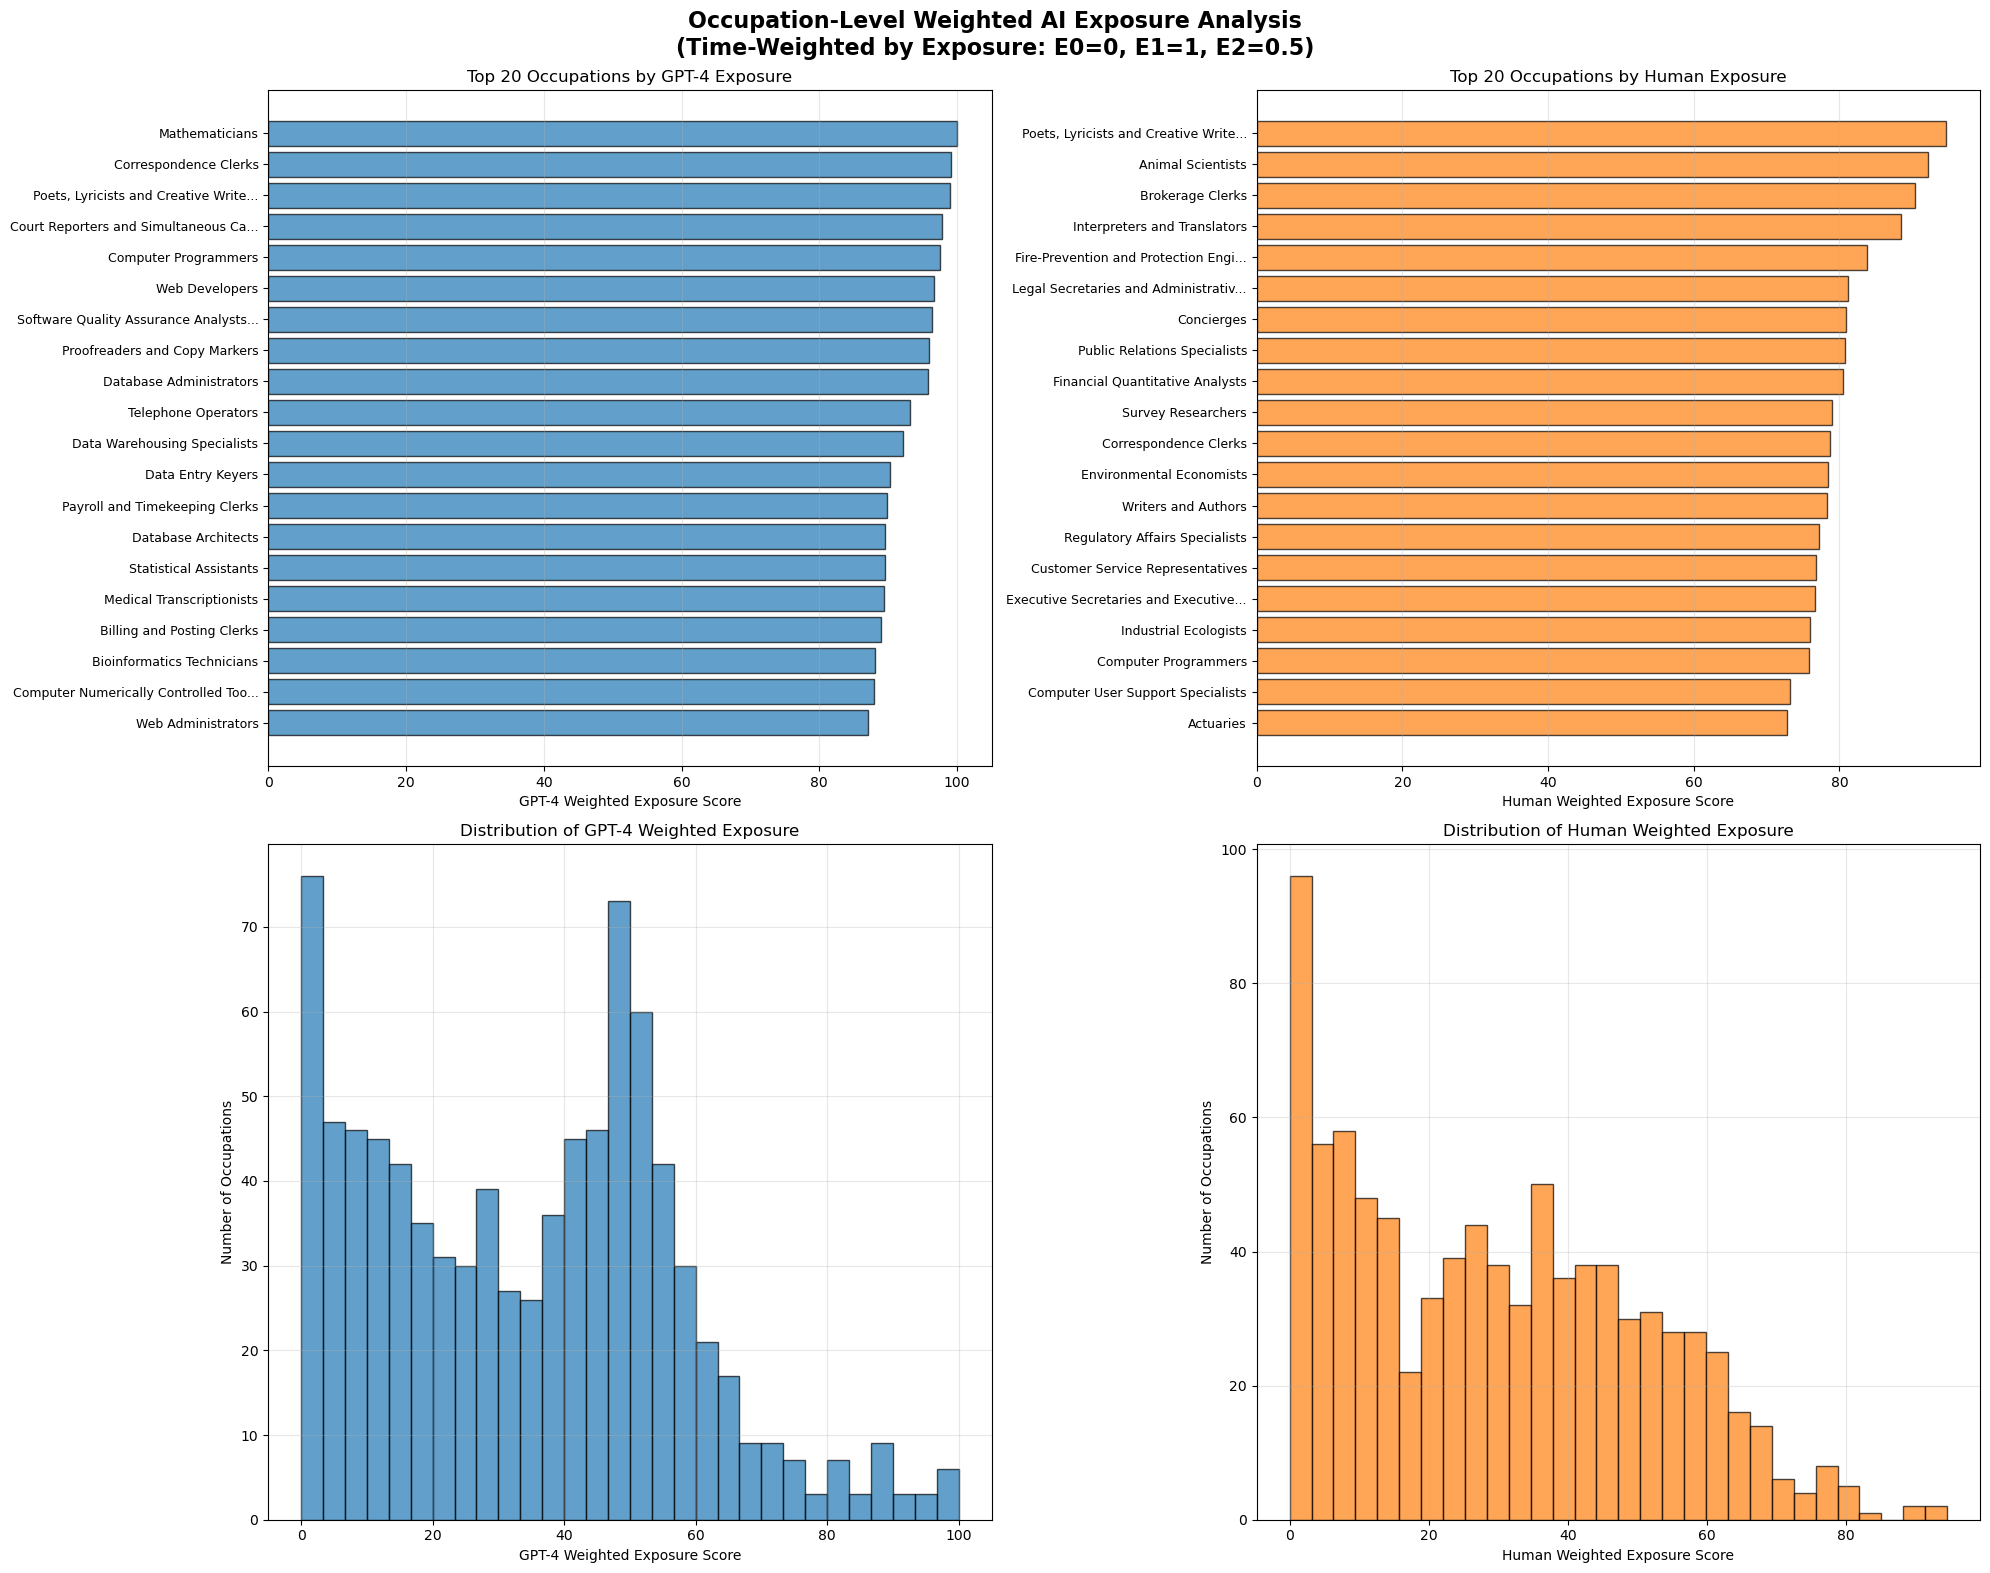

WEIGHTED EXPOSURE ANALYSIS SUMMARY

Correlation between GPT-4 and Human weighted exposure:
  Correlation: 0.8460
  P-value: 3.89e-240
  Significance: ***

Method explanation:
  • Each task gets exposure weight: E0=0, E1=1, E2=0.5
  • Multiply task time percentage by exposure weight
  • Sum across all tasks within each occupation
  • Higher scores = more time spent on high-exposure tasks
  • Based on 873 occupations with valid data

✓ Saved weighted exposure dataset to: ../data/computed_objects/occupation_weighted_exposure.csv
INTERPRETATION OF WEIGHTED EXPOSURE SCORES

The weighted exposure score represents how much time an occupation spends on high-exposure tasks:

• Formula: Sum across all tasks of (Task_Time_Percentage × Exposure_Weight)
• Exposure weights: E0 = 0 points, E1 = 1 point, E2 = 0.5 points
• Range: 0 (no exposed tasks) to 100 (100% time on E1 tasks)

Examples:
• Score of 0: All tasks are E0 (no exposure)
• Score of 50: 50% time on E1 tasks, 50% on E0 tasks
• Score of 25:

In [126]:
# Create visualizations for weighted exposure measures
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Occupation-Level Weighted AI Exposure Analysis\n(Time-Weighted by Exposure: E0=0, E1=1, E2=0.5)', fontsize=16, fontweight='bold', y=0.98)

# 1. Top 20 occupations by GPT-4 weighted exposure
ax1 = axes[0, 0]
top_20_gpt4 = occupation_exposure.nlargest(20, 'GPT4_Weighted_Exposure')
y_pos = np.arange(len(top_20_gpt4))

# Truncate long occupation titles
titles_truncated_gpt4 = [title[:35] + '...' if len(title) > 35 else title 
                        for title in top_20_gpt4['Occupation Title']]

bars = ax1.barh(y_pos, top_20_gpt4['GPT4_Weighted_Exposure'], 
                alpha=0.7, color='#1f77b4', edgecolor='black')
ax1.set_yticks(y_pos)
ax1.set_yticklabels(titles_truncated_gpt4, fontsize=9)
ax1.set_xlabel('GPT-4 Weighted Exposure Score')
ax1.set_title('Top 20 Occupations by GPT-4 Exposure')
ax1.grid(True, alpha=0.3, axis='x')
ax1.invert_yaxis()

# 2. Top 20 occupations by Human weighted exposure  
ax2 = axes[0, 1]
top_20_human = occupation_exposure.nlargest(20, 'Human_Weighted_Exposure')
y_pos = np.arange(len(top_20_human))

# Truncate long occupation titles
titles_truncated_human = [title[:35] + '...' if len(title) > 35 else title 
                         for title in top_20_human['Occupation Title']]

bars = ax2.barh(y_pos, top_20_human['Human_Weighted_Exposure'], 
                alpha=0.7, color='#ff7f0e', edgecolor='black')
ax2.set_yticks(y_pos)
ax2.set_yticklabels(titles_truncated_human, fontsize=9)
ax2.set_xlabel('Human Weighted Exposure Score')
ax2.set_title('Top 20 Occupations by Human Exposure')
ax2.grid(True, alpha=0.3, axis='x')
ax2.invert_yaxis()

# 3. Distribution of GPT-4 weighted exposure
ax3 = axes[1, 0]
ax3.hist(occupation_exposure['GPT4_Weighted_Exposure'], bins=30, alpha=0.7, color='#1f77b4', edgecolor='black')
ax3.set_xlabel('GPT-4 Weighted Exposure Score')
ax3.set_ylabel('Number of Occupations')
ax3.set_title('Distribution of GPT-4 Weighted Exposure')
ax3.grid(True, alpha=0.3)

# 4. Distribution of Human weighted exposure
ax4 = axes[1, 1]
ax4.hist(occupation_exposure['Human_Weighted_Exposure'], bins=30, alpha=0.7, color='#ff7f0e', edgecolor='black')
ax4.set_xlabel('Human Weighted Exposure Score')
ax4.set_ylabel('Number of Occupations')
ax4.set_title('Distribution of Human Weighted Exposure')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.subplots_adjust(top=0.93)

# Save the plot
plt.savefig(f'{output_plot_path}/weighted_ai_exposure_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("="*80)
print("WEIGHTED EXPOSURE ANALYSIS SUMMARY")
print("="*80)

print(f"\nCorrelation between GPT-4 and Human weighted exposure:")
correlation, p_value = stats.pearsonr(occupation_exposure['GPT4_Weighted_Exposure'], 
                                     occupation_exposure['Human_Weighted_Exposure'])
print(f"  Correlation: {correlation:.4f}")
print(f"  P-value: {p_value:.2e}")
print(f"  Significance: {'***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'n.s.'}")

print(f"\nMethod explanation:")
print(f"  • Each task gets exposure weight: E0=0, E1=1, E2=0.5")
print(f"  • Multiply task time percentage by exposure weight")
print(f"  • Sum across all tasks within each occupation")
print(f"  • Higher scores = more time spent on high-exposure tasks")
print(f"  • Based on {len(occupation_exposure):,} occupations with valid data")

# Save the weighted exposure dataset
occupation_exposure.to_csv(f'{output_data_path}/occupation_weighted_exposure.csv', index=False)
print(f"\n✓ Saved weighted exposure dataset to: {output_data_path}/occupation_weighted_exposure.csv")

print("="*80)
print("INTERPRETATION OF WEIGHTED EXPOSURE SCORES")
print("="*80)
print("""
The weighted exposure score represents how much time an occupation spends on high-exposure tasks:

• Formula: Sum across all tasks of (Task_Time_Percentage × Exposure_Weight)
• Exposure weights: E0 = 0 points, E1 = 1 point, E2 = 0.5 points
• Range: 0 (no exposed tasks) to 100 (100% time on E1 tasks)

Examples:
• Score of 0: All tasks are E0 (no exposure)
• Score of 50: 50% time on E1 tasks, 50% on E0 tasks
• Score of 25: 50% time on E2 tasks, 50% on E0 tasks  
• Score of 100: 100% time on E1 tasks (maximum exposure)

Higher scores indicate occupations where workers spend more time on AI-exposed tasks.
""")

In [127]:
ONET[ONET['O*NET-SOC Code'] == '17-2051.02'].sort_values('Task Title').reset_index(drop=True)

,O*NET-SOC Code,Occupation Title,Task ID,Task Title,Task Type,Job Zone,Task_Time_Percentage,FT_Daily,FT_Hourly or more,FT_More than monthly,...,alpha,beta,gamma,automation,human_labels,task_weight,gpt4_E1,gpt4_E2,human_E1,human_E2
0,17-2051.02,Water/Wastewater Engineers,16343,"Analyze and recommend chemical, biological, or...",Core,4,2.69,16.67,0.00,44.44,...,0.00,0.50,1.00,0.50,E0,1.00,0,1,0,0
1,17-2051.02,Water/Wastewater Engineers,16342,Analyze and recommend sludge treatment or disp...,Core,4,1.31,4.76,0.00,9.52,...,0.00,0.50,1.00,0.50,E2,1.00,0,1,0,1
2,17-2051.02,Water/Wastewater Engineers,16341,Analyze storm water or floodplain drainage sys...,Core,4,1.94,12.50,0.00,31.25,...,0.00,0.50,1.00,0.25,E2,1.00,0,1,0,1
3,17-2051.02,Water/Wastewater Engineers,16340,Analyze the efficiency of water delivery struc...,Core,4,1.00,0.00,0.00,0.00,...,0.00,0.50,1.00,0.50,E2,1.00,0,1,0,1
4,17-2051.02,Water/Wastewater Engineers,16339,Conduct cost-benefit analyses for the construc...,Core,4,1.06,0.00,0.00,35.00,...,0.00,0.50,1.00,0.50,E2,1.00,0,1,0,1
5,17-2051.02,Water/Wastewater Engineers,16338,Conduct environmental impact studies related t...,Core,4,0.50,0.00,0.00,41.18,...,0.00,0.50,1.00,0.50,E2,1.00,0,1,0,1
6,17-2051.02,Water/Wastewater Engineers,16337,Conduct feasibility studies for the constructi...,Core,4,1.83,0.00,0.00,28.57,...,0.00,0.50,1.00,0.50,E1,1.00,0,1,1,0
7,17-2051.02,Water/Wastewater Engineers,16331,Conduct water quality studies to identify and ...,Core,4,1.77,6.67,0.00,33.33,...,0.00,0.50,1.00,0.50,E2,1.00,0,1,0,1
8,17-2051.02,Water/Wastewater Engineers,16350,Design domestic or industrial water or wastewa...,Core,4,2.95,14.29,0.00,38.10,...,0.00,0.00,0.00,0.25,E1,1.00,0,0,1,0
9,17-2051.02,Water/Wastewater Engineers,16330,Design or select equipment for use in wastewat...,Core,4,2.46,9.52,0.00,33.33,...,0.00,0.50,1.00,0.50,E2,1.00,0,1,0,1


In [128]:
# Create DWA-level dataset by assigning the most frequent exposure rating to each DWA
print("="*80)
print("DWA-LEVEL ANALYSIS: ASSIGNING DOMINANT EXPOSURE RATINGS")
print("="*80)

def get_dominant_exposure(dwa_tasks, exposure_col):
    """
    Get the exposure rating with the highest frequency for a DWA.
    Returns the exposure rating (E0, E1, E2) that appears most frequently.
    """
    exposure_counts = dwa_tasks[exposure_col].value_counts()
    if len(exposure_counts) == 0:
        return None
    return exposure_counts.index[0]  # Return the most frequent exposure rating

# Create DWA-level dataset
dwa_level_data = []

for dwa_id in ONET_with_DWAs_labeled['DWA ID'].unique():
    # Get all tasks for this DWA
    dwa_tasks = ONET_with_DWAs_labeled[ONET_with_DWAs_labeled['DWA ID'] == dwa_id].copy()
    
    if len(dwa_tasks) == 0:
        continue
    
    # Get basic DWA information from the first row (all should be the same for a DWA)
    first_row = dwa_tasks.iloc[0]
    
    # Get dominant exposure ratings
    gpt4_dominant = get_dominant_exposure(dwa_tasks, 'gpt4_exposure')
    human_dominant = get_dominant_exposure(dwa_tasks, 'human_labels')
    
    # Skip if we don't have exposure data
    if gpt4_dominant is None or human_dominant is None:
        continue
    
    # Create DWA-level record
    dwa_record = {
        'DWA ID': dwa_id,
        'DWA Title': first_row['DWA Title'],
        'O*NET-SOC Code': first_row['O*NET-SOC Code'],
        'Occupation Title': first_row['Occupation Title'],
        'Major_Group_Code': first_row['Major_Group_Code'],
        'Major_Group_Title': first_row['Major_Group_Title'],
        'Minor_Group_Code': first_row['Minor_Group_Code'],
        'Minor_Group_Title': first_row['Minor_Group_Title'],
        'Broad_Occupation_Code': first_row['Broad_Occupation_Code'],
        'Broad_Occupation_Title': first_row['Broad_Occupation_Title'],
        'Detailed_Occupation_Code': first_row['Detailed_Occupation_Code'],
        'Detailed_Occupation_Title': first_row['Detailed_Occupation_Title'],
        'gpt4_exposure': gpt4_dominant,
        'human_labels': human_dominant,
        'num_tasks': len(dwa_tasks),
        'num_unique_gpt4_ratings': dwa_tasks['gpt4_exposure'].nunique(),
        'num_unique_human_ratings': dwa_tasks['human_labels'].nunique()
    }
    
    dwa_level_data.append(dwa_record)

# Convert to DataFrame
ONET_DWA_level = pd.DataFrame(dwa_level_data)

print(f"Created DWA-level dataset with {len(ONET_DWA_level):,} DWAs")

# Show distribution of assigned exposure ratings
print(f"\nDistribution of dominant GPT-4 exposure ratings:")
gpt4_dist_dwa = ONET_DWA_level['gpt4_exposure'].value_counts().sort_index()
for rating, count in gpt4_dist_dwa.items():
    percentage = (count / len(ONET_DWA_level)) * 100
    print(f"  {rating}: {count:,} DWAs ({percentage:.1f}%)")

print(f"\nDistribution of dominant Human exposure ratings:")
human_dist_dwa = ONET_DWA_level['human_labels'].value_counts().sort_index()
for rating, count in human_dist_dwa.items():
    percentage = (count / len(ONET_DWA_level)) * 100
    print(f"  {rating}: {count:,} DWAs ({percentage:.1f}%)")

# Show some examples
print(f"\nExamples of DWA exposure assignments:")
example_dwas = ONET_DWA_level[['DWA Title', 'gpt4_exposure', 'human_labels', 'num_tasks', 
                              'num_unique_gpt4_ratings', 'num_unique_human_ratings']].head(10)
print(example_dwas.to_string(index=False))

ONET_DWA_level.head(5)

DWA-LEVEL ANALYSIS: ASSIGNING DOMINANT EXPOSURE RATINGS
Created DWA-level dataset with 2,081 DWAs

Distribution of dominant GPT-4 exposure ratings:
  E0: 959 DWAs (46.1%)
  E1: 207 DWAs (9.9%)
  E2: 915 DWAs (44.0%)

Distribution of dominant Human exposure ratings:
  E0: 1,125 DWAs (54.1%)
  E1: 291 DWAs (14.0%)
  E2: 665 DWAs (32.0%)

Examples of DWA exposure assignments:
                                                                   DWA Title gpt4_exposure human_labels  num_tasks  num_unique_gpt4_ratings  num_unique_human_ratings
                                                Direct financial operations.            E2           E2         18                        2                         3
           Confer with organizational members to accomplish work activities.            E2           E1         29                        2                         3
                Analyze data to assess operational or project effectiveness.            E2           E2          5            

,DWA ID,DWA Title,O*NET-SOC Code,Occupation Title,Major_Group_Code,Major_Group_Title,Minor_Group_Code,Minor_Group_Title,Broad_Occupation_Code,Broad_Occupation_Title,Detailed_Occupation_Code,Detailed_Occupation_Title,gpt4_exposure,human_labels,num_tasks,num_unique_gpt4_ratings,num_unique_human_ratings
0,4.A.4.b.4.I09.D02,Direct financial operations.,11-1011.00,Chief Executives,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives,E2,E2,18,2,3
1,4.A.4.a.2.I03.D14,Confer with organizational members to accompli...,11-1011.00,Chief Executives,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives,E2,E1,29,2,3
2,4.A.2.a.4.I07.D09,Analyze data to assess operational or project ...,11-1011.00,Chief Executives,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives,E2,E2,5,1,2
3,4.A.2.b.1.I09.D01,Implement organizational process or policy cha...,11-1011.00,Chief Executives,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives,E2,E2,50,3,3
4,4.A.2.b.4.I01.D01,Develop organizational policies or programs.,11-1011.00,Chief Executives,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives,E2,E1,26,2,2


In [129]:
# Compute DWA-level exposure scores using the same methodology as task-level
print("\n" + "="*80)
print("COMPUTING DWA-LEVEL EXPOSURE SCORES")
print("="*80)

def compute_dwa_exposure_shares(df, exposure_col, prefix):
    """
    Compute exposure shares at occupation level using DWA-level data.
    Each DWA is treated as a unit (no task weighting since we're at DWA level).
    """
    # One-hot exposure indicators
    df[f"{prefix}_E1"] = (df[exposure_col] == "E1").astype(int)
    df[f"{prefix}_E2"] = (df[exposure_col] == "E2").astype(int)
    
    # Shares per occupation (simple count-based since each DWA is one unit)
    occ_level = (
        df.groupby(["O*NET-SOC Code", "Occupation Title"])
        .agg({
            f"{prefix}_E1": 'mean',  # fraction of DWAs with E1
            f"{prefix}_E2": 'mean'   # fraction of DWAs with E2
        })
        .reset_index()
    )
    
    # Rename columns to match task-level naming
    occ_level = occ_level.rename(columns={
        f"{prefix}_E1": f"{prefix}_E1_share",
        f"{prefix}_E2": f"{prefix}_E2_share"
    })
    
    # Composite measures
    occ_level[f"{prefix}_E1_plus_halfE2"] = occ_level[f"{prefix}_E1_share"] + 0.5 * occ_level[f"{prefix}_E2_share"]
    occ_level[f"{prefix}_E1_plus_E2"] = occ_level[f"{prefix}_E1_share"] + occ_level[f"{prefix}_E2_share"]
    
    occ_level = occ_level.drop(columns=[f'{prefix}_E2_share'])
    
    occ_level = occ_level.rename(columns={
        f'{prefix}_E1_share': f'{prefix}_alpha',
        f'{prefix}_E1_plus_halfE2': f'{prefix}_beta',
        f'{prefix}_E1_plus_E2': f'{prefix}_gamma'
    })
    
    return occ_level

# Compute DWA-level exposure shares for GPT-4 and human ratings
gpt4_exposure_scores_dwa = compute_dwa_exposure_shares(ONET_DWA_level, "gpt4_exposure", "gpt4")
human_exposure_scores_dwa = compute_dwa_exposure_shares(ONET_DWA_level, "human_labels", "human")

# Merge GPT-4 and human exposure scores
exposure_scores_occupation_dwa = pd.merge(gpt4_exposure_scores_dwa, human_exposure_scores_dwa, 
                                         on=["O*NET-SOC Code", "Occupation Title"])

print(f"Number of occupations in DWA-level analysis: {len(exposure_scores_occupation_dwa)}")

# Display the results
exposure_scores_occupation_dwa.head(10)


COMPUTING DWA-LEVEL EXPOSURE SCORES
Number of occupations in DWA-level analysis: 536


,O*NET-SOC Code,Occupation Title,gpt4_alpha,gpt4_beta,gpt4_gamma,human_alpha,human_beta,human_gamma
0,11-1011.00,Chief Executives,0.00,0.48,0.96,0.19,0.48,0.78
1,11-1011.03,Chief Sustainability Officers,0.12,0.53,0.94,0.12,0.50,0.88
2,11-1021.00,General and Operations Managers,0.00,0.50,1.00,0.33,0.46,0.58
3,11-2011.00,Advertising and Promotions Managers,0.00,0.50,1.00,0.18,0.55,0.91
4,11-2021.00,Marketing Managers,0.00,0.50,1.00,0.00,0.50,1.00
5,11-2022.00,Sales Managers,0.00,0.50,1.00,0.25,0.62,1.00
6,11-3012.00,Administrative Services Managers,0.00,0.50,1.00,0.00,0.00,0.00
7,11-3021.00,Computer and Information Systems Managers,0.00,0.50,1.00,0.33,0.50,0.67
8,11-3031.00,Financial Managers,0.00,0.50,1.00,0.00,0.50,1.00
9,11-3031.01,Treasurers and Controllers,0.20,0.50,0.80,0.00,0.10,0.20


In [130]:
# Function to compute hierarchical DWA-level exposure scores
def compute_hierarchical_dwa_exposure(df, code_col, title_col, exposure_col, prefix):
    """
    Compute exposure shares at a hierarchical level using DWA-level data.
    """
    # Create a copy to avoid modifying original
    df_copy = df.copy()
    
    # One-hot exposure indicators
    df_copy[f"{prefix}_E1"] = (df_copy[exposure_col] == "E1").astype(int)
    df_copy[f"{prefix}_E2"] = (df_copy[exposure_col] == "E2").astype(int)
    
    # Filter out rows with NaN exposure values
    df_copy = df_copy[df_copy[exposure_col].notna()]
    
    # Shares per hierarchical level (simple fractions since each DWA is one unit)
    level_exposure = (
        df_copy.groupby([code_col, title_col])
        .agg({
            f"{prefix}_E1": 'mean',  # fraction of DWAs with E1
            f"{prefix}_E2": 'mean'   # fraction of DWAs with E2
        })
        .reset_index()
    )
    
    # Rename columns
    level_exposure = level_exposure.rename(columns={
        f"{prefix}_E1": f"{prefix}_E1_share",
        f"{prefix}_E2": f"{prefix}_E2_share"
    })
    
    # Composite measures
    level_exposure[f"{prefix}_alpha"] = level_exposure[f"{prefix}_E1_share"]
    level_exposure[f"{prefix}_beta"] = level_exposure[f"{prefix}_E1_share"] + 0.5 * level_exposure[f"{prefix}_E2_share"]
    level_exposure[f"{prefix}_gamma"] = level_exposure[f"{prefix}_E1_share"] + level_exposure[f"{prefix}_E2_share"]
    
    # Drop E2_share and E1_share as they're not needed in final output
    level_exposure = level_exposure.drop(columns=[f'{prefix}_E2_share', f'{prefix}_E1_share'])
    
    # Rename to standard column names
    level_exposure = level_exposure.rename(columns={
        code_col: 'Code',
        title_col: 'Title'
    })
    
    return level_exposure

# Define hierarchical levels (same as before)
hierarchical_levels = [
    ('Major_Group_Code', 'Major_Group_Title', 'Major Group'),
    ('Minor_Group_Code', 'Minor_Group_Title', 'Minor Group'),
    ('Broad_Occupation_Code', 'Broad_Occupation_Title', 'Broad Occupation'),
    ('Detailed_Occupation_Code', 'Detailed_Occupation_Title', 'Detailed Occupation')
]

# Compute DWA-level exposure scores for each hierarchical level
print("\nComputing hierarchical DWA-level exposure scores...")
for code_col, title_col, level_name in hierarchical_levels:
    # Compute GPT-4 exposure
    gpt4_exp = compute_hierarchical_dwa_exposure(ONET_DWA_level, code_col, title_col, 'gpt4_exposure', 'gpt4')
    
    # Compute human exposure
    human_exp = compute_hierarchical_dwa_exposure(ONET_DWA_level, code_col, title_col, 'human_labels', 'human')

    # Merge GPT-4 and human exposure scores
    combined_exp = pd.merge(gpt4_exp, human_exp, on=['Code', 'Title'])
    combined_exp['Level'] = level_name
    
    # Reorder columns
    combined_exp = combined_exp[['Level', 'Code', 'Title', 
                                  'gpt4_alpha', 'gpt4_beta', 'gpt4_gamma',
                                  'human_alpha', 'human_beta', 'human_gamma']]
    
    print(f"  {level_name}: {len(combined_exp)} groups")

print("✓ Computed hierarchical DWA-level exposure scores")


Computing hierarchical DWA-level exposure scores...
  Major Group: 22 groups
  Minor Group: 91 groups
  Broad Occupation: 315 groups
  Detailed Occupation: 471 groups
✓ Computed hierarchical DWA-level exposure scores


In [131]:
# Create a combined hierarchical DWA-level exposure dataset (all 5 levels in one file)
print("\nCreating combined DWA-level exposure dataset...")

all_dwa_exposure_levels = []

# Add hierarchical-level exposure scores
for code_col, title_col, level_name in hierarchical_levels:
    gpt4_exp = compute_hierarchical_dwa_exposure(ONET_DWA_level, code_col, title_col, 'gpt4_exposure', 'gpt4')
    human_exp = compute_hierarchical_dwa_exposure(ONET_DWA_level, code_col, title_col, 'human_labels', 'human')
    
    combined_exp = pd.merge(gpt4_exp, human_exp, on=['Code', 'Title'])
    combined_exp['Level'] = level_name
    combined_exp = combined_exp[['Level', 'Code', 'Title',
                                  'gpt4_alpha', 'gpt4_beta', 'gpt4_gamma',
                                  'human_alpha', 'human_beta', 'human_gamma']]
    
    all_dwa_exposure_levels.append(combined_exp)

# Add occupation-level exposure scores (most granular)
occupation_exposure_dwa = exposure_scores_occupation_dwa.copy()
occupation_exposure_dwa['Level'] = 'Occupation'
occupation_exposure_dwa = occupation_exposure_dwa.rename(columns={'O*NET-SOC Code': 'Code', 'Occupation Title': 'Title'})
occupation_exposure_dwa = occupation_exposure_dwa[['Level', 'Code', 'Title',
                                                   'gpt4_alpha', 'gpt4_beta', 'gpt4_gamma',
                                                   'human_alpha', 'human_beta', 'human_gamma']]
all_dwa_exposure_levels.append(occupation_exposure_dwa)

# Combine all 5 levels
exposure_scores_all_levels_dwa = pd.concat(all_dwa_exposure_levels, ignore_index=True)

print(f"\nCombined DWA-Level Exposure Dataset (All 5 Levels):")
print(f"  Total rows: {len(exposure_scores_all_levels_dwa):,}")
print(f"\nBreakdown by level:")
for level_name in ['Major Group', 'Minor Group', 'Broad Occupation', 'Detailed Occupation', 'Occupation']:
    count = len(exposure_scores_all_levels_dwa[exposure_scores_all_levels_dwa['Level'] == level_name])
    print(f"  {level_name}: {count}")

# Save the DWA-level dataset
exposure_scores_all_levels_dwa.to_csv(f'{output_data_path}/exposure_scores_all_levels_dwa.csv', index=False)
print(f"\n✓ Saved DWA-level exposure scores to: {output_data_path}/exposure_scores_all_levels_dwa.csv")

exposure_scores_all_levels_dwa.head(10)


Creating combined DWA-level exposure dataset...

Combined DWA-Level Exposure Dataset (All 5 Levels):
  Total rows: 1,435

Breakdown by level:
  Major Group: 22
  Minor Group: 91
  Broad Occupation: 315
  Detailed Occupation: 471
  Occupation: 536

✓ Saved DWA-level exposure scores to: ../data/computed_objects/exposure_scores_all_levels_dwa.csv


,Level,Code,Title,gpt4_alpha,gpt4_beta,gpt4_gamma,human_alpha,human_beta,human_gamma
0,Major Group,11-0000,Management Occupations,0.07,0.47,0.86,0.15,0.42,0.69
1,Major Group,13-0000,Business and Financial Operations Occupations,0.12,0.55,0.98,0.27,0.57,0.86
2,Major Group,15-0000,Computer and Mathematical Occupations,0.52,0.73,0.94,0.28,0.61,0.94
3,Major Group,17-0000,Architecture and Engineering Occupations,0.07,0.43,0.79,0.18,0.40,0.61
4,Major Group,19-0000,"Life, Physical, and Social Science Occupations",0.05,0.40,0.75,0.26,0.46,0.66
5,Major Group,21-0000,Community and Social Service Occupations,0.07,0.28,0.48,0.16,0.29,0.41
6,Major Group,23-0000,Legal Occupations,0.14,0.48,0.81,0.10,0.36,0.62
7,Major Group,25-0000,Educational Instruction and Library Occupations,0.10,0.34,0.57,0.19,0.33,0.47
8,Major Group,27-0000,"Arts, Design, Entertainment, Sports, and Media...",0.11,0.44,0.77,0.17,0.37,0.57
9,Major Group,29-0000,Healthcare Practitioners and Technical Occupat...,0.06,0.27,0.48,0.15,0.27,0.39


In [132]:
# Create DWA count analysis for merging
print("\nCreating DWA count analysis...")

# Function to compute DWA counts at different hierarchical levels
def compute_dwa_counts_by_level(df, code_col, title_col, level_name):
    """Compute number of unique DWAs at a hierarchical level"""
    level_counts = df.groupby([code_col, title_col]).agg({
        'DWA ID': 'nunique'
    }).reset_index()
    
    level_counts = level_counts.rename(columns={
        code_col: 'Code',
        title_col: 'Title',
        'DWA ID': 'num_unique_dwas'
    })
    
    level_counts['Level'] = level_name
    return level_counts[['Level', 'Code', 'Title', 'num_unique_dwas']]

# Compute DWA counts for each hierarchical level
all_dwa_counts = []

for code_col, title_col, level_name in hierarchical_levels:
    level_counts = compute_dwa_counts_by_level(ONET_DWA_level, code_col, title_col, level_name)
    all_dwa_counts.append(level_counts)

# Add occupation-level counts
occ_counts = compute_dwa_counts_by_level(ONET_DWA_level, 'O*NET-SOC Code', 'Occupation Title', 'Occupation')
all_dwa_counts.append(occ_counts)

# Combine all levels
dwa_counts_all_levels = pd.concat(all_dwa_counts, ignore_index=True)

# Merge DWA counts with exposure scores
exposure_scores_with_dwa_counts = exposure_scores_all_levels_dwa.merge(
    dwa_counts_all_levels,
    on=['Level', 'Code', 'Title'], 
    how='left'
)

# Check merge statistics
print(f"\nDWA Count Merge Statistics:")
print(f"  Rows before merge (exposure scores): {len(exposure_scores_all_levels_dwa):,}")
print(f"  Rows in DWA counts dataset: {len(dwa_counts_all_levels):,}")
print(f"  Rows after merge: {len(exposure_scores_with_dwa_counts):,}")
print(f"  Rows with missing DWA counts: {exposure_scores_with_dwa_counts['num_unique_dwas'].isna().sum():,}")

if exposure_scores_with_dwa_counts['num_unique_dwas'].isna().sum() > 0:
    print(f"\nRows with missing DWA counts:")
    missing_rows = exposure_scores_with_dwa_counts[exposure_scores_with_dwa_counts['num_unique_dwas'].isna()]
    print(missing_rows[['Level', 'Code', 'Title']])
    
    # Drop rows with missing DWA counts
    exposure_scores_with_dwa_counts = exposure_scores_with_dwa_counts.dropna(subset=['num_unique_dwas'])
    print(f"\nAfter dropping rows with missing counts: {len(exposure_scores_with_dwa_counts):,} rows remaining")
else:
    print(f"\n✓ All rows successfully merged!")

# Convert count column to integer
exposure_scores_with_dwa_counts['num_unique_dwas'] = exposure_scores_with_dwa_counts['num_unique_dwas'].astype(int)

# Save the combined dataset
exposure_scores_with_dwa_counts.to_csv(f'{output_data_path}/exposure_scores_with_dwa_counts.csv', index=False)

print(f"\nCombined DWA-Level Exposure + Counts Dataset:")
print(f"  Total rows: {len(exposure_scores_with_dwa_counts):,}")
print(f"\nBreakdown by level:")
for level_name in ['Major Group', 'Minor Group', 'Broad Occupation', 'Detailed Occupation', 'Occupation']:
    count = len(exposure_scores_with_dwa_counts[exposure_scores_with_dwa_counts['Level'] == level_name])
    print(f"  {level_name}: {count}")

exposure_scores_with_dwa_counts.head(10)


Creating DWA count analysis...

DWA Count Merge Statistics:
  Rows before merge (exposure scores): 1,435
  Rows in DWA counts dataset: 1,435
  Rows after merge: 1,435
  Rows with missing DWA counts: 0

✓ All rows successfully merged!

Combined DWA-Level Exposure + Counts Dataset:
  Total rows: 1,435

Breakdown by level:
  Major Group: 22
  Minor Group: 91
  Broad Occupation: 315
  Detailed Occupation: 471
  Occupation: 536


,Level,Code,Title,gpt4_alpha,gpt4_beta,gpt4_gamma,human_alpha,human_beta,human_gamma,num_unique_dwas
0,Major Group,11-0000,Management Occupations,0.07,0.47,0.86,0.15,0.42,0.69,188
1,Major Group,13-0000,Business and Financial Operations Occupations,0.12,0.55,0.98,0.27,0.57,0.86,146
2,Major Group,15-0000,Computer and Mathematical Occupations,0.52,0.73,0.94,0.28,0.61,0.94,89
3,Major Group,17-0000,Architecture and Engineering Occupations,0.07,0.43,0.79,0.18,0.40,0.61,158
4,Major Group,19-0000,"Life, Physical, and Social Science Occupations",0.05,0.40,0.75,0.26,0.46,0.66,175
5,Major Group,21-0000,Community and Social Service Occupations,0.07,0.28,0.48,0.16,0.29,0.41,56
6,Major Group,23-0000,Legal Occupations,0.14,0.48,0.81,0.10,0.36,0.62,21
7,Major Group,25-0000,Educational Instruction and Library Occupations,0.10,0.34,0.57,0.19,0.33,0.47,86
8,Major Group,27-0000,"Arts, Design, Entertainment, Sports, and Media...",0.11,0.44,0.77,0.17,0.37,0.57,90
9,Major Group,29-0000,Healthcare Practitioners and Technical Occupat...,0.06,0.27,0.48,0.15,0.27,0.39,140


In [133]:
# DWA-level plots: Create figures showing DWA counts vs exposure across hierarchical levels
print("\nCreating DWA-level exposure plots...")

# Define the levels in order from most aggregated to most granular
levels_to_plot = ['Major Group', 'Minor Group', 'Broad Occupation', 'Detailed Occupation', 'Occupation']

# Define exposure measures to use
exposure_measures = ['alpha', 'beta', 'gamma']

# Update output path for DWA plots
output_plot_path_dwa = f"{main_folder_path}/writeup/plots/dwacounts_aiexposure"
os.makedirs(output_plot_path_dwa, exist_ok=True)

# Create one comprehensive plot for each exposure measure
for exposure_measure in exposure_measures:
    # Create figure with 5x2 subplots (5 levels × 2 exposure types)
    fig, axes = plt.subplots(5, 2, figsize=(18, 22))
    
    fig.suptitle(f'DWA Counts vs {exposure_measure.capitalize()} Exposure Across Hierarchical Levels\n\n\n', 
                fontsize=18, fontweight='bold', y=0.995)
    
    # Calculate global x-axis limits for this exposure measure to ensure consistent scaling
    all_gpt4_values = []
    all_human_values = []
    
    for level_name in levels_to_plot:
        level_data = exposure_scores_with_dwa_counts[exposure_scores_with_dwa_counts['Level'] == level_name].copy()
        gpt4_vals = level_data[f'gpt4_{exposure_measure}'].values
        human_vals = level_data[f'human_{exposure_measure}'].values
        
        # Remove NaN values for range calculation
        gpt4_clean = gpt4_vals[~np.isnan(gpt4_vals)]
        human_clean = human_vals[~np.isnan(human_vals)]
        
        if len(gpt4_clean) > 0:
            all_gpt4_values.extend(gpt4_clean)
        if len(human_clean) > 0:
            all_human_values.extend(human_clean)
    
    # Set consistent x-axis limits with margins for a clean 0-1 range
    x_margin = 0.05  # 5% margin on each side
    gpt4_xlim = (-x_margin, 1 + x_margin)
    human_xlim = (-x_margin, 1 + x_margin)
    
    # Loop through each hierarchical level
    for level_idx, level_name in enumerate(levels_to_plot):
        # Filter data for current level
        level_data = exposure_scores_with_dwa_counts[exposure_scores_with_dwa_counts['Level'] == level_name].copy()
        n_obs = len(level_data)
        
        # Left column: GPT-4 exposure
        ax_gpt4 = axes[level_idx, 0]
        
        # Get data for DWAs
        x_gpt4 = level_data[f'gpt4_{exposure_measure}'].values
        y_dwas = level_data['num_unique_dwas'].values
        
        # Plot DWAs (blue circles)
        ax_gpt4.scatter(x_gpt4, y_dwas, alpha=0.7, color='steelblue', edgecolors='white', 
                       linewidth=0.5, s=60, label='DWAs')
        
        # Fit and plot regression lines
        if len(x_gpt4) > 1 and not np.all(np.isnan(x_gpt4)):
            # DWAs regression line
            valid_idx_dwas = ~(np.isnan(x_gpt4) | np.isnan(y_dwas))
            if np.sum(valid_idx_dwas) > 1:
                x_clean = x_gpt4[valid_idx_dwas]
                y_clean = y_dwas[valid_idx_dwas]
                slope_dwas, intercept_dwas = np.polyfit(x_clean, y_clean, 1)
                x_fit = np.linspace(x_clean.min(), x_clean.max(), 100)
                y_fit_dwas = slope_dwas * x_fit + intercept_dwas
                ax_gpt4.plot(x_fit, y_fit_dwas, color='steelblue', linewidth=2, alpha=0.8, 
                           linestyle='-', label=f'DWAs slope: {slope_dwas:.2f}')
        
        ax_gpt4.set_xlabel(f'GPT-4 {exposure_measure.capitalize()} Exposure', fontsize=12)
        ax_gpt4.set_ylabel('DWA Count', fontsize=12)
        ax_gpt4.set_title(f'{level_name} (n={n_obs}): GPT-4 Exposure', fontsize=13, fontweight='bold')
        ax_gpt4.grid(True, alpha=0.3)
        ax_gpt4.legend(fontsize=10, loc='upper right')
        ax_gpt4.set_xlim(gpt4_xlim)  # Set consistent x-axis limits (0-1 with margins)
        
        # Right column: Human exposure
        ax_human = axes[level_idx, 1]
        
        # Get data for DWAs
        x_human = level_data[f'human_{exposure_measure}'].values
        
        # Plot DWAs (red circles)
        ax_human.scatter(x_human, y_dwas, alpha=0.7, color='indianred', edgecolors='white', 
                        linewidth=0.5, s=60, label='DWAs')
        
        # Fit and plot regression lines
        if len(x_human) > 1 and not np.all(np.isnan(x_human)):
            # DWAs regression line
            valid_idx_dwas = ~(np.isnan(x_human) | np.isnan(y_dwas))
            if np.sum(valid_idx_dwas) > 1:
                x_clean = x_human[valid_idx_dwas]
                y_clean = y_dwas[valid_idx_dwas]
                slope_dwas_h, intercept_dwas_h = np.polyfit(x_clean, y_clean, 1)
                x_fit_h = np.linspace(x_clean.min(), x_clean.max(), 100)
                y_fit_dwas_h = slope_dwas_h * x_fit_h + intercept_dwas_h
                ax_human.plot(x_fit_h, y_fit_dwas_h, color='indianred', linewidth=2, alpha=0.8, 
                            linestyle='-', label=f'DWAs slope: {slope_dwas_h:.2f}')
        
        ax_human.set_xlabel(f'Human {exposure_measure.capitalize()} Exposure', fontsize=12)
        ax_human.set_ylabel('DWA Count', fontsize=12)
        ax_human.set_title(f'{level_name} (n={n_obs}): Human Exposure', fontsize=13, fontweight='bold')
        ax_human.grid(True, alpha=0.3)
        ax_human.legend(fontsize=10, loc='upper right')
        ax_human.set_xlim(human_xlim)  # Set consistent x-axis limits (0-1 with margins)
    
    # Add main column headers
    axes[0, 0].text(0.5, 1.12, 'GPT-4 Exposure', transform=axes[0, 0].transAxes, 
                   ha='center', va='bottom', fontsize=16, fontweight='bold')
    axes[0, 1].text(0.5, 1.12, 'Human Exposure', transform=axes[0, 1].transAxes, 
                   ha='center', va='bottom', fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.96, hspace=0.35, wspace=0.25)
    
    # Save figure
    filename = f'dwa_counts_vs_exposure_{exposure_measure}.png'
    plt.savefig(f'{output_plot_path_dwa}/{filename}', dpi=300, bbox_inches='tight')
    plt.close()

print(f"✓ Saved {len(exposure_measures)} DWA-level plots to: {output_plot_path_dwa}/")

# Summary comparison: Task-level vs DWA-level
print("\n" + "="*80)
print("SUMMARY: TASK-LEVEL vs DWA-LEVEL ANALYSIS COMPARISON")
print("="*80)
print(f"Task-level analysis:")
print(f"  Total tasks analyzed: {len(ONET):,}")
print(f"  Occupations: {len(exposure_scores_occupation):,}")

print(f"\nDWA-level analysis:")
print(f"  Total DWAs analyzed: {len(ONET_DWA_level):,}")
print(f"  Occupations: {len(exposure_scores_occupation_dwa):,}")

print(f"\nKey differences:")
print(f"  • Task-level: Uses task weighting (Core=1.0, Supplemental=0.5)")
print(f"  • DWA-level: Each DWA treated as equal unit")
print(f"  • Task-level: Captures within-DWA exposure variation")
print(f"  • DWA-level: Uses dominant exposure rating per DWA")
print(f"  • Both approaches provide different perspectives on AI exposure measurement")


Creating DWA-level exposure plots...
✓ Saved 3 DWA-level plots to: ../writeup/plots/dwacounts_aiexposure/

SUMMARY: TASK-LEVEL vs DWA-LEVEL ANALYSIS COMPARISON
Task-level analysis:
  Total tasks analyzed: 17,953
  Occupations: 873

DWA-level analysis:
  Total DWAs analyzed: 2,081
  Occupations: 536

Key differences:
  • Task-level: Uses task weighting (Core=1.0, Supplemental=0.5)
  • DWA-level: Each DWA treated as equal unit
  • Task-level: Captures within-DWA exposure variation
  • DWA-level: Uses dominant exposure rating per DWA
  • Both approaches provide different perspectives on AI exposure measurement
✓ Saved 3 DWA-level plots to: ../writeup/plots/dwacounts_aiexposure/

SUMMARY: TASK-LEVEL vs DWA-LEVEL ANALYSIS COMPARISON
Task-level analysis:
  Total tasks analyzed: 17,953
  Occupations: 873

DWA-level analysis:
  Total DWAs analyzed: 2,081
  Occupations: 536

Key differences:
  • Task-level: Uses task weighting (Core=1.0, Supplemental=0.5)
  • DWA-level: Each DWA treated as equ